# Advanced Regression Techniques to Forecast Bushfires

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- caret
- data.table
- dplyr
- e1071
- GGally
- ggplot2
- grid
- gridExtra
- lattice
- leaps
- MASS
- PerformanceAnalytics


## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)



## 1. Introduction <a class="anchor" id="sec_1"></a>

In this project we aim to create models that can predict the area burned in fires. We will be working with data from the UCI machine learning [repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) and is a collection curated by scientists Paulo Cortez and Anibal Morais from the Unviersity of Minho, Portugal. 

The data includes meteorological measurements taken at the time the fire was reported, `spatial/temporal measurements, and index metrics` that take into a account weather data in the recent past. The index metrics are a part of the **Canadian Fire Weather Index System (FWI)**. The data was collected from January 2000 to December 2003 from the northeast region of Portugal. Data was collected from a total of 517 fires.

Many different ML models can be applied - in the basis [paper](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) the one who achieved the best performance was Support Vector Machines (SVM). However, in this project we will be testing advanced regression techniques only. 

Our work will follow the steps:
1. Perform data exploration and understand the trends in the dataset. 
2. Do necessary data manipulations such as data reshaping and outlier removal to enhance the dataset.
3. Create models to predict the burned area according to different regression techniques.
4. Compare the models performance and choose a winner.
5. Explain the most relevant predictors according to the models and the data exploration.


#### Attribute information: Provided with the data

**1. Spatial information**
   - `X`:      x-axis spatial coordinate within the Montesinho park map: 1 to 9
   -  `Y`:     y-axis spatial coordinate within the Montesinho park map: 2 to 9
   
**2. Temporal information**
   - `month`:  month of the year: "jan" to "dec" 
   - `day`:    day of the week: "mon" to "sun"
   
**3. FWI: The forest Fire Weather Index (FWI). Which is the Canadian system for rating fire danger.**
   - `FFMC`:   FFMC index from the FWI system: 18.7 to 96.20
   - `DMC`:    DMC index from the FWI system: 1.1 to 291.3 
   - `DC`:     DC index from the FWI system: 7.9 to 860.6 
   - `ISI`:    ISI index from the FWI system: 0.0 to 56.10
   
**4. Methorological information**
   - `temp`:   temperature in Celsius degrees: 2.2 to 33.30
   - `RH`:     relative humidity in %: 15.0 to 100
   - `wind`:   wind speed in km/h: 0.40 to 9.40 
   - `rain`:   outside rain in mm/m2 : 0.0 to 6.4 
   
**5. area**:   the burned area of the forest (in ha): 0.00 to 1090.84 

#### Importing Libraries

In [2]:
library(ggplot2) # for improved plots
library(GGally) # for scatterplot matrix
library(e1071) # For ML functions
library(MASS) # For ML functions
library(data.table) # manipultaion such as inner joins
library(grid) # functions and classes that represent graphical objects or grobs
library(gridExtra) # organizing plots
library(lattice) # for levelplot
library(dplyr) # for data manipulation
library(PerformanceAnalytics) 
library(caret) # 
library(leaps) # for regsubsets function

## 2. Data Exploration<a class="anchor" id="sec_2"></a>

#### Load the data

In [3]:
df_fires <- read.csv(file="forestfires.csv", header=TRUE, sep=",")
head(df_fires) # Dysplay first six rows of the table 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


####  Understanding the burned area distribution 
As previously stated we aim to predict the area of the fire according to the other variables. it is logical that we start our data exploration from the area. A first look at the table above show that the area is 0 in all of the first rows which is a concern. The authors in their *paper* have explained that an area smaller than $100m^2$ is replaced by 0. Lets check the distribution of the burned area using an histogram.

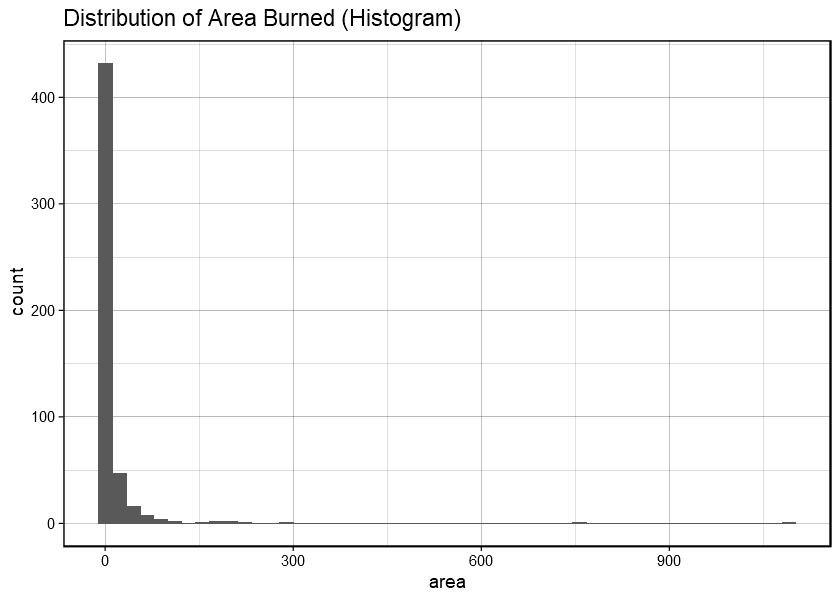

In [4]:
options(repr.plot.width=7, repr.plot.height=5) # area of display

ggplot(df_fires, aes(area)) + 
geom_histogram(bins = 50) + 
theme_linedraw() + 
ggtitle("Distribution of Area Burned (Histogram)")


This is an extremely skewed variable and most likely to make a prediction we will have to handle it accordingly. We plan to do a regression in the future and this might be a problem, because for the residuals to be normal the predicted variable should not be extremely skewed distribution. A possible first strategy is to apply transformatio methods such as the `logarithm` and see how the data will reshape. <br>
**Important:** As we saw many of the data points of area are equal to 0 - so we cannot pass the pure log, but instead we will apply the formula <br>

$y = (log_{10}x+1)$.

#### Log transformation on the area

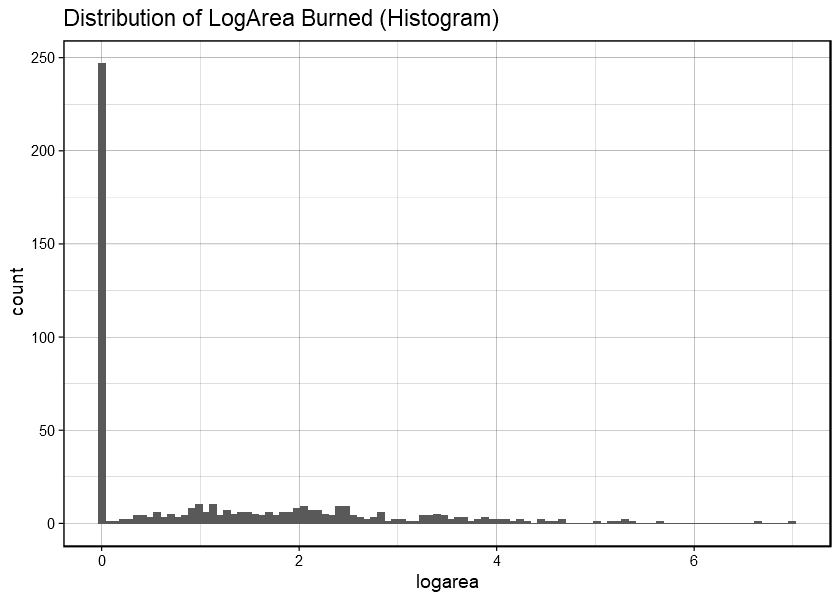

In [5]:
df_fires$logarea <- log(df_fires$area+1)

# plotting the new distribution
ggplot(df_fires, aes(logarea)) + 
geom_histogram(bins = 100) + 
theme_linedraw() + 
ggtitle("Distribution of LogArea Burned (Histogram)")

Our data remains skilled, however, can see small improve in the distribution of the data. We will make a final analysis, by checking what happens if we do not consider the very small fires (size 0). 

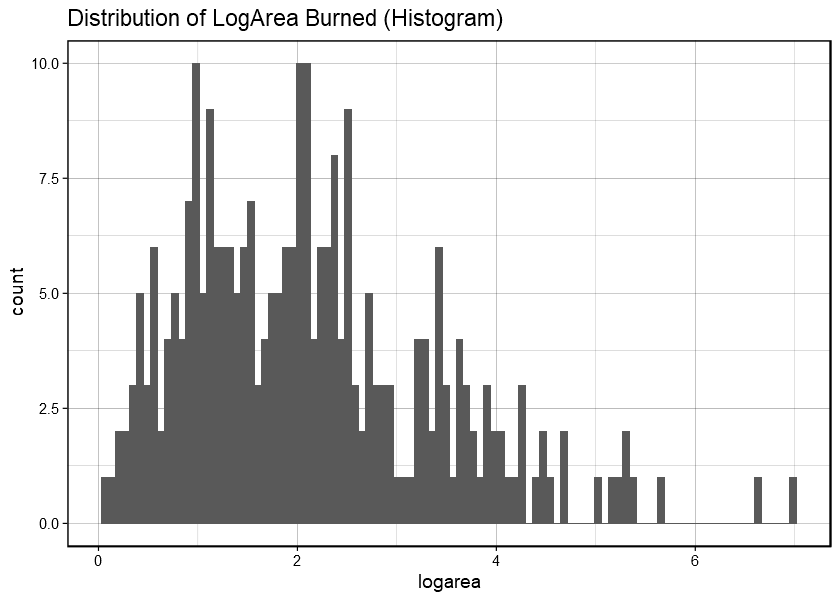

In [6]:
ggplot(df_fires[df_fires$logarea!= 0,], aes(logarea)) + 
geom_histogram(bins = 100) + 
theme_linedraw() + 
ggtitle("Distribution of LogArea Burned (Histogram)")

Observations regarding the distribution of the data:
1. The distribution of the burned area is very skill and this might be a problem for modelling. 
2. We have made a first log transformation that made slight improve.
3. If we exclude the close to 0 fires we will find a closely normal distribution which might be good to work with for modelling tasks.


### Spatial Analysis
The dataset contains spatial information representing the fires location. The X and Y variables represent the geographical locations in a map and can only be analysed together to make sense. The X axis ranges from 1 to 9 (integers) while the y axis from 2 to 9. Together, they form an area of 72 spaces. We will develop heatmaps in the folowing to identify areas that have been particular areas of focus of fires with respect to:
- The area affected.
- The number of fires.
- Other variables that we might want to compare

In [7]:
# create a table
# grouping other variables by area
df_spatial <- df_fires %>%
  group_by(X,Y) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n(), 
            temp = median(temp, na.rm = TRUE),
            RH = median(RH, na.rm = TRUE),
            wind = median(wind, na.rm = TRUE),
            rain = median(rain, na.rm = TRUE),
            FFMC = median(FFMC, na.rm = TRUE),
            DMC = median(DMC, na.rm = TRUE),
            DC = median(DC, na.rm = TRUE),
            ISI = median(ISI, na.rm = TRUE)
           )

We want to develop a very specific heatmap, with many different features. To simplify the process of plotting we will create a function that will be used to make applied to make different plots.

In [8]:
areaheatplot <- function(scale, tittle) 

{
    Total.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = scale)) + 
    ggtitle(tittle) +
    geom_tile(position=position_nudge(x = 0.5, y= 0.5),  colour = "blue") + 
    theme_linedraw() + 
    theme(panel.grid.major = element_line(colour = "blue")) +
    scale_fill_gradient(low="orange", high="red", na.value ="white") + 
    geom_text(aes(label = round(scale, 1)), position=position_nudge(x = 0.5, y= 0.5)) + 
    scale_x_discrete(breaks=seq(1, 10, 1), limits = seq(1, 10, 1))  + 
    scale_y_discrete(breaks=seq(1, 9, 1), limits = seq(1, 9, 1))
    return (Total.heatmap)
}

Now, we will investigate different trends that data may show according to the region in which the fire happened. Firstly, we will try to observe some areas are more likely to have fires than others.

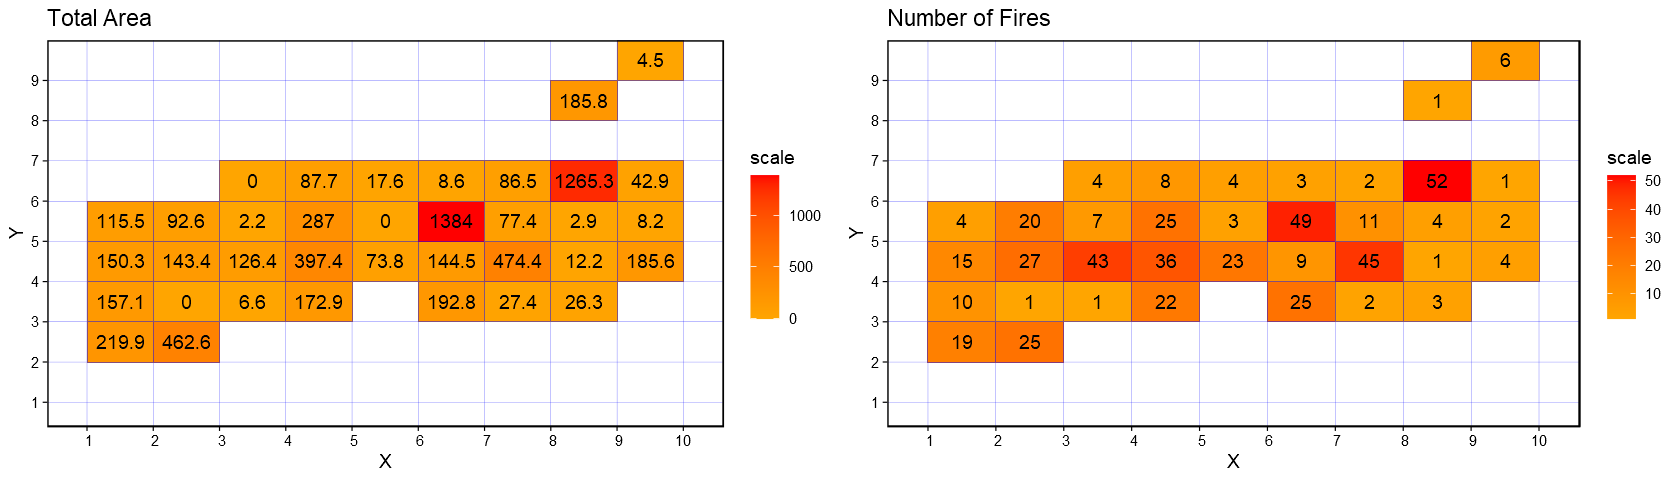

In [9]:
area_plot <- areaheatplot(df_spatial$Total_Area, "Total Area")
count_plot <- areaheatplot(df_spatial$Count_Fires, "Number of Fires")
options(repr.plot.width=14, repr.plot.height=4) # managing the size
grid.arrange(area_plot, count_plot, nrow = 1, ncol = 2) # making the plot

Observations:
- Clearly there are more area that are more prone to fires than others.
- The interesection between X (6-9) and Y (4-7) accounts for more than half of fires.
- Most regions did not have fires at all.

Now, we will try to explore the metheorological conditions by region to see if areas that have more fires have any peculiar trends. We will build 8 plots, regions against: Temperature, RH, Wind, Rain, FFMC, DMC, DC, ISI.


In [10]:
temp_plot <- areaheatplot(df_spatial$temp, "Temperature")
RH_plot <- areaheatplot(df_spatial$RH, "RH")
wind_plot <- areaheatplot(df_spatial$wind, "Wind")
rain_plot <- areaheatplot(df_spatial$rain, "Rain")
FFMC_plot <- areaheatplot(df_spatial$FFMC, "FFMC")
DMC_plot <- areaheatplot(df_spatial$DMC, "DMC")
DC_plot <- areaheatplot(df_spatial$DC, "DC")
ISI_plot <- areaheatplot(df_spatial$ISI, "ISI")

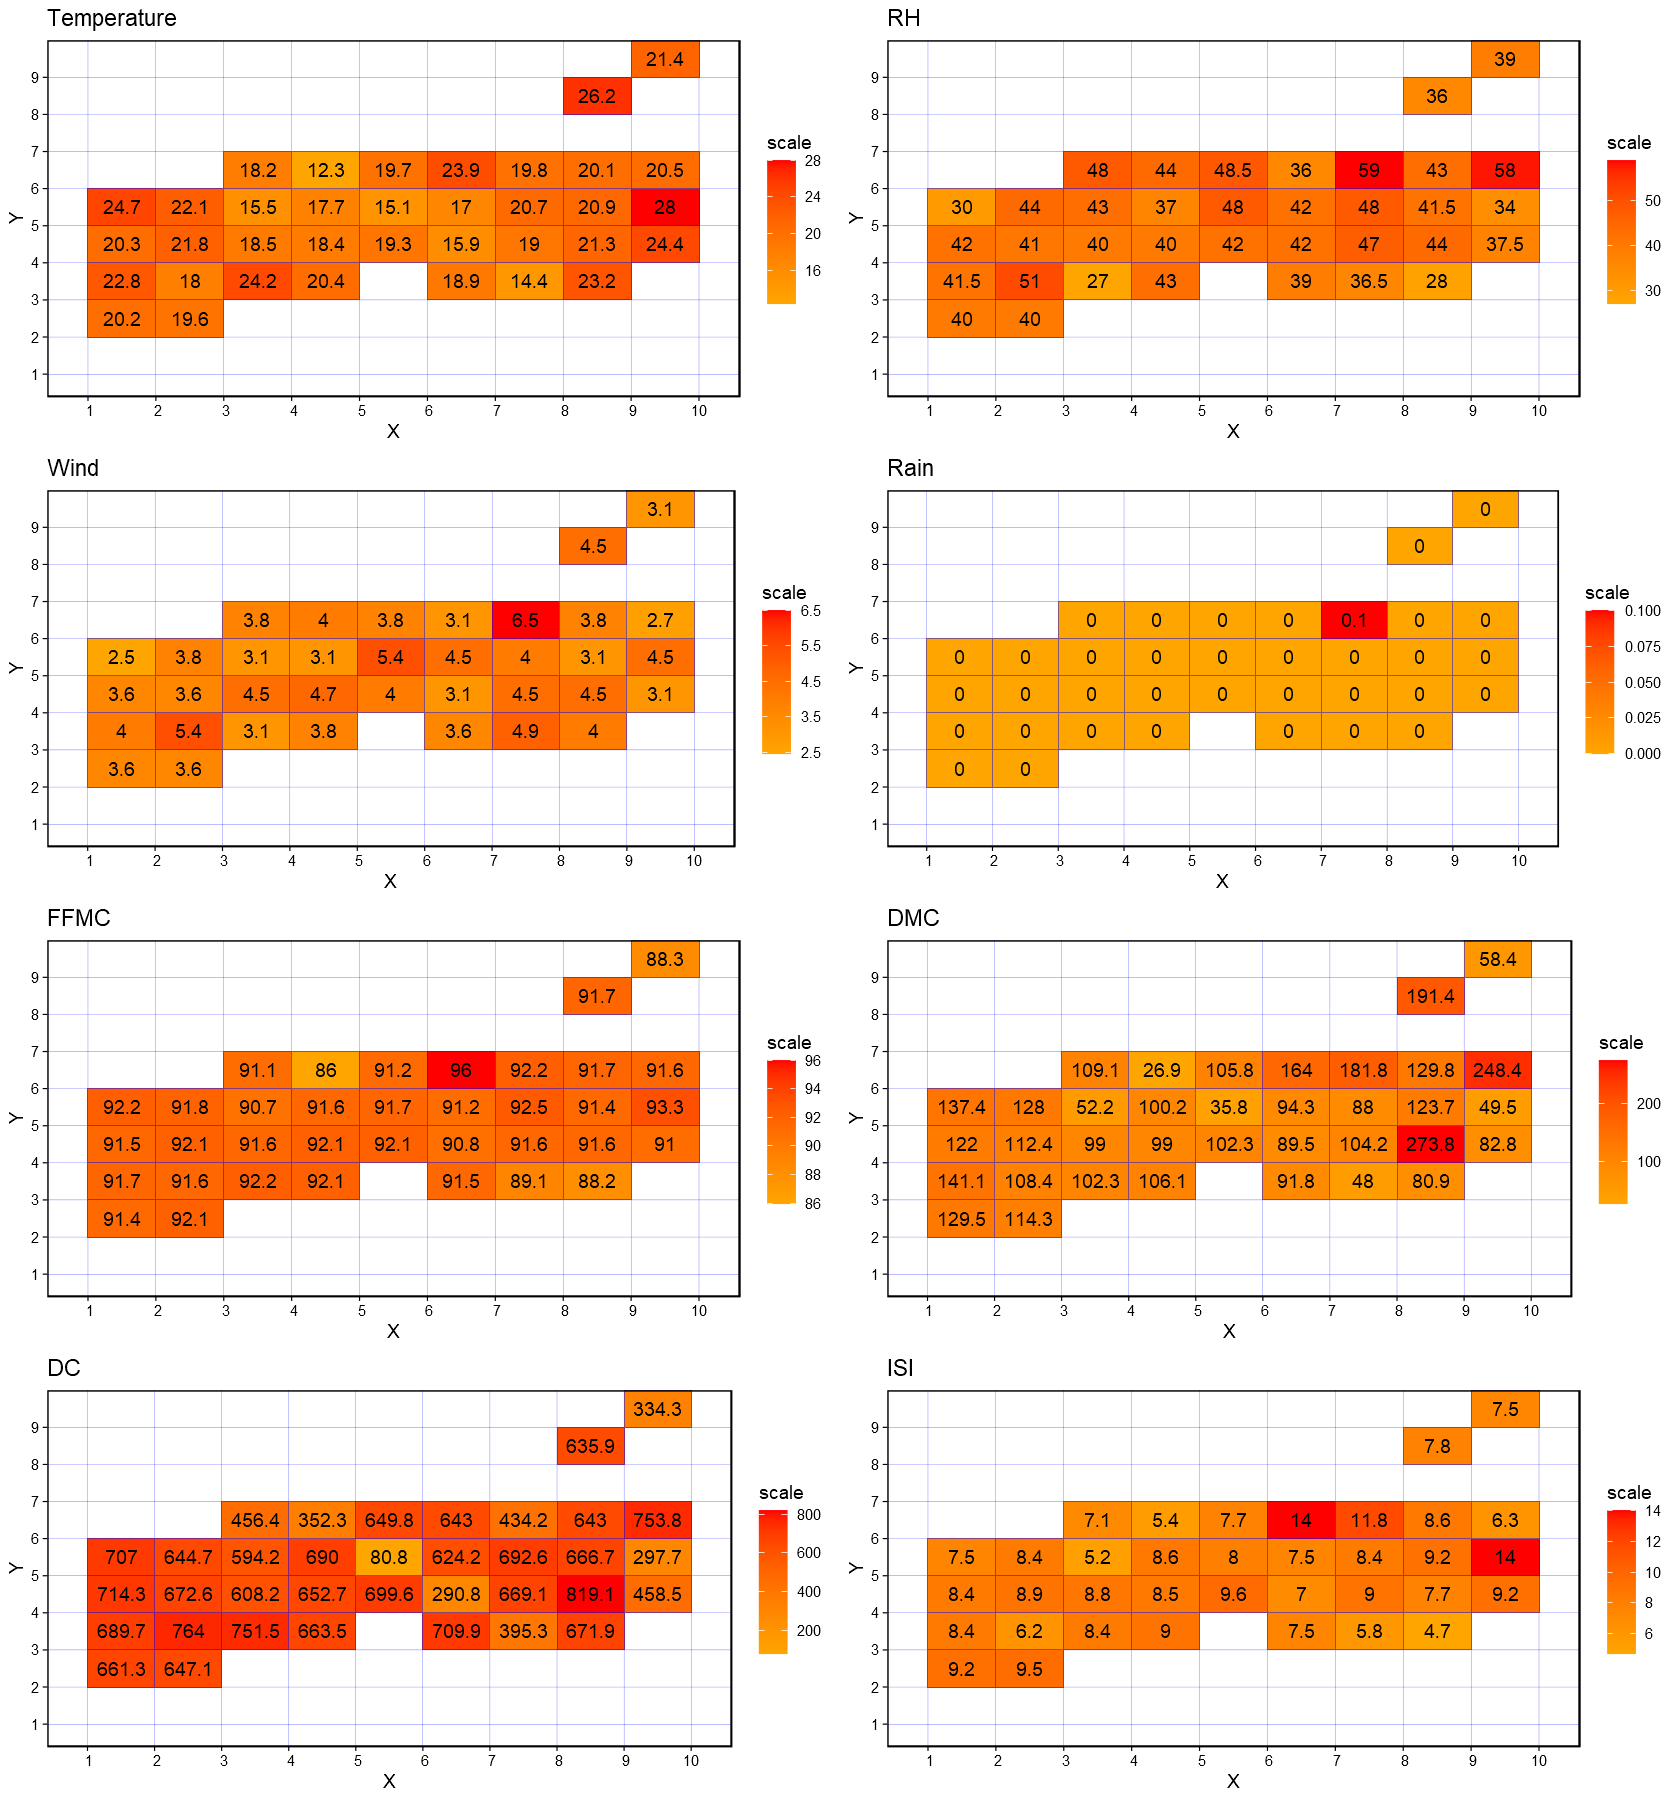

In [11]:
options(repr.plot.width=14, repr.plot.height=15) # managing the size
grid.arrange(temp_plot, RH_plot, wind_plot, rain_plot, FFMC_plot, DMC_plot, DC_plot, ISI_plot,
             nrow = 4, ncol = 2) # making the plot

Observations:
- The latest charts are very useful to explore visually the relationship of variables with areas. 
- Due to complexity, it is difficult to arrive to conclusions for modelling purposes. 
-  Apparently areas with more fires also have higher proportion of the other variables such as higher temperatures and Relative Humidity. <br> 


####  Creating New Dummy Variables for Risky Areas -  One Hot Encoding of Regions

A region is a area formed by a X and a Y point. In total, there are 72 regions - with X ranging from 1-9 and Y raging from 2-9. Therefore we will create a new variable called region, because it will be better to analyse the data considering that hardly X and Y independently would make sense to analyse.<br>
As we have seen there are areas that are more prone to fires than others. This was explored even with relationship to other variables. We want our model to be able to capture this "risk" so we will make some modifications in our dataset. We will create dummy variables for all regions that concentrate more than 2% (at least 10) of the number of fires. We have chosen this threshold because we do not want our future models to overfit by using this new variables.

In [12]:
# adding region variable
df_area <- data.frame(Region = 1:72, X = 1:9, Y = 2:9)
df_fires <- left_join(df_fires, df_area, by = c("X", "Y"))

# group by region the number of fires
df_spatial <- df_fires %>%
  group_by(Region) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n())

# filter areas with more than 10 fires
attach(df_spatial)
df_spatial <- df_spatial[which(Count_Fires > 10),]
detach(df_spatial)

danger_areas <- df_spatial$Region 
cat("Danger Areas: Regions that have more than 10 registered fires \n", df_spatial$Region)

Danger Areas: Regions that have more than 10 registered fires 
 1 3 4 11 19 20 42 43 52 53 58 59 60 65 67

In [13]:
# creating dummy variables
for(i in (danger_areas)){
    df_fires[,paste0("Region", i)] <- ifelse(test = df_fires$Region == i, yes = 1, no = 0)
}


We have created 15 dummy variables that may be characterized as risk regions. 

#### Temporal Analysis

We will further investigate the temporal dimension of the dataset. We want to know if fires are more likely to happen in a especific day or month. We noted, however, that it might be better to explore the data according to seasonality and weekends, because we beleive they should be better predictors. We will now:
1. Create new variables, a dummy for weekends and a seasonality variable.
2. Explore the trends of the variables `weekends`, `seasonality`, `month` and `day`. 


In [65]:
# create variable season
df_fires$season <- ifelse(df_fires$month == "aug" | df_fires$month == "jun" | df_fires$month == "jul",'summer', 
                          ifelse(df_fires$month == "oct" | df_fires$month == "nov" | df_fires$month == "sep","autumn",
                                 ifelse(df_fires$month == "feb" | df_fires$month == "jan" | df_fires$month =="dec", "winter",
                                        ifelse(df_fires$month == "mar" | df_fires$month == "apr" | df_fires$month =='may', "spring", 'NA'))))

In [66]:
# create variable weekend
# note that we consider fruday a weekend day
df_fires$weekend <- ifelse(df_fires$day == "mon" | df_fires$day == "tue" | df_fires$day == "wed"| df_fires$day == "thu", 0,1)

In [67]:
# creating a table with the count of fires
df_season <- df_fires %>%
  group_by(season, month, day, weekend) %>%
  summarize(Total_Area = sum(logarea, na.rm = TRUE),
            Count_Fires  = n())

In [71]:
day_order <- c("mon", "tue", "wed", "thu", "fri", "sat", "sun" )
season_order <- c("summer", "autumn", "winter", "spring") # Natural order of seasons
month_order <- c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec")

p1 <- ggplot(df_fires, aes(x= factor(month, level = month_order), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Month")
p2 <- ggplot(df_season, aes(x= factor(month, level = month_order), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Month")

p3 <- ggplot(df_fires, aes(x= factor(season, level = season_order), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Season")
p4 <- ggplot(df_season, aes(x= factor(season, level = season_order), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Season")

p5 <- ggplot(df_fires, aes(x= factor(day, level = day_order), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Day")
p6 <- ggplot(df_season, aes(x= factor(day, level = day_order), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Day")

p7 <- ggplot(df_fires, aes(x= factor(weekend), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Weekend")
p8 <- ggplot(df_season, aes(x= factor(weekend), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Weekend")

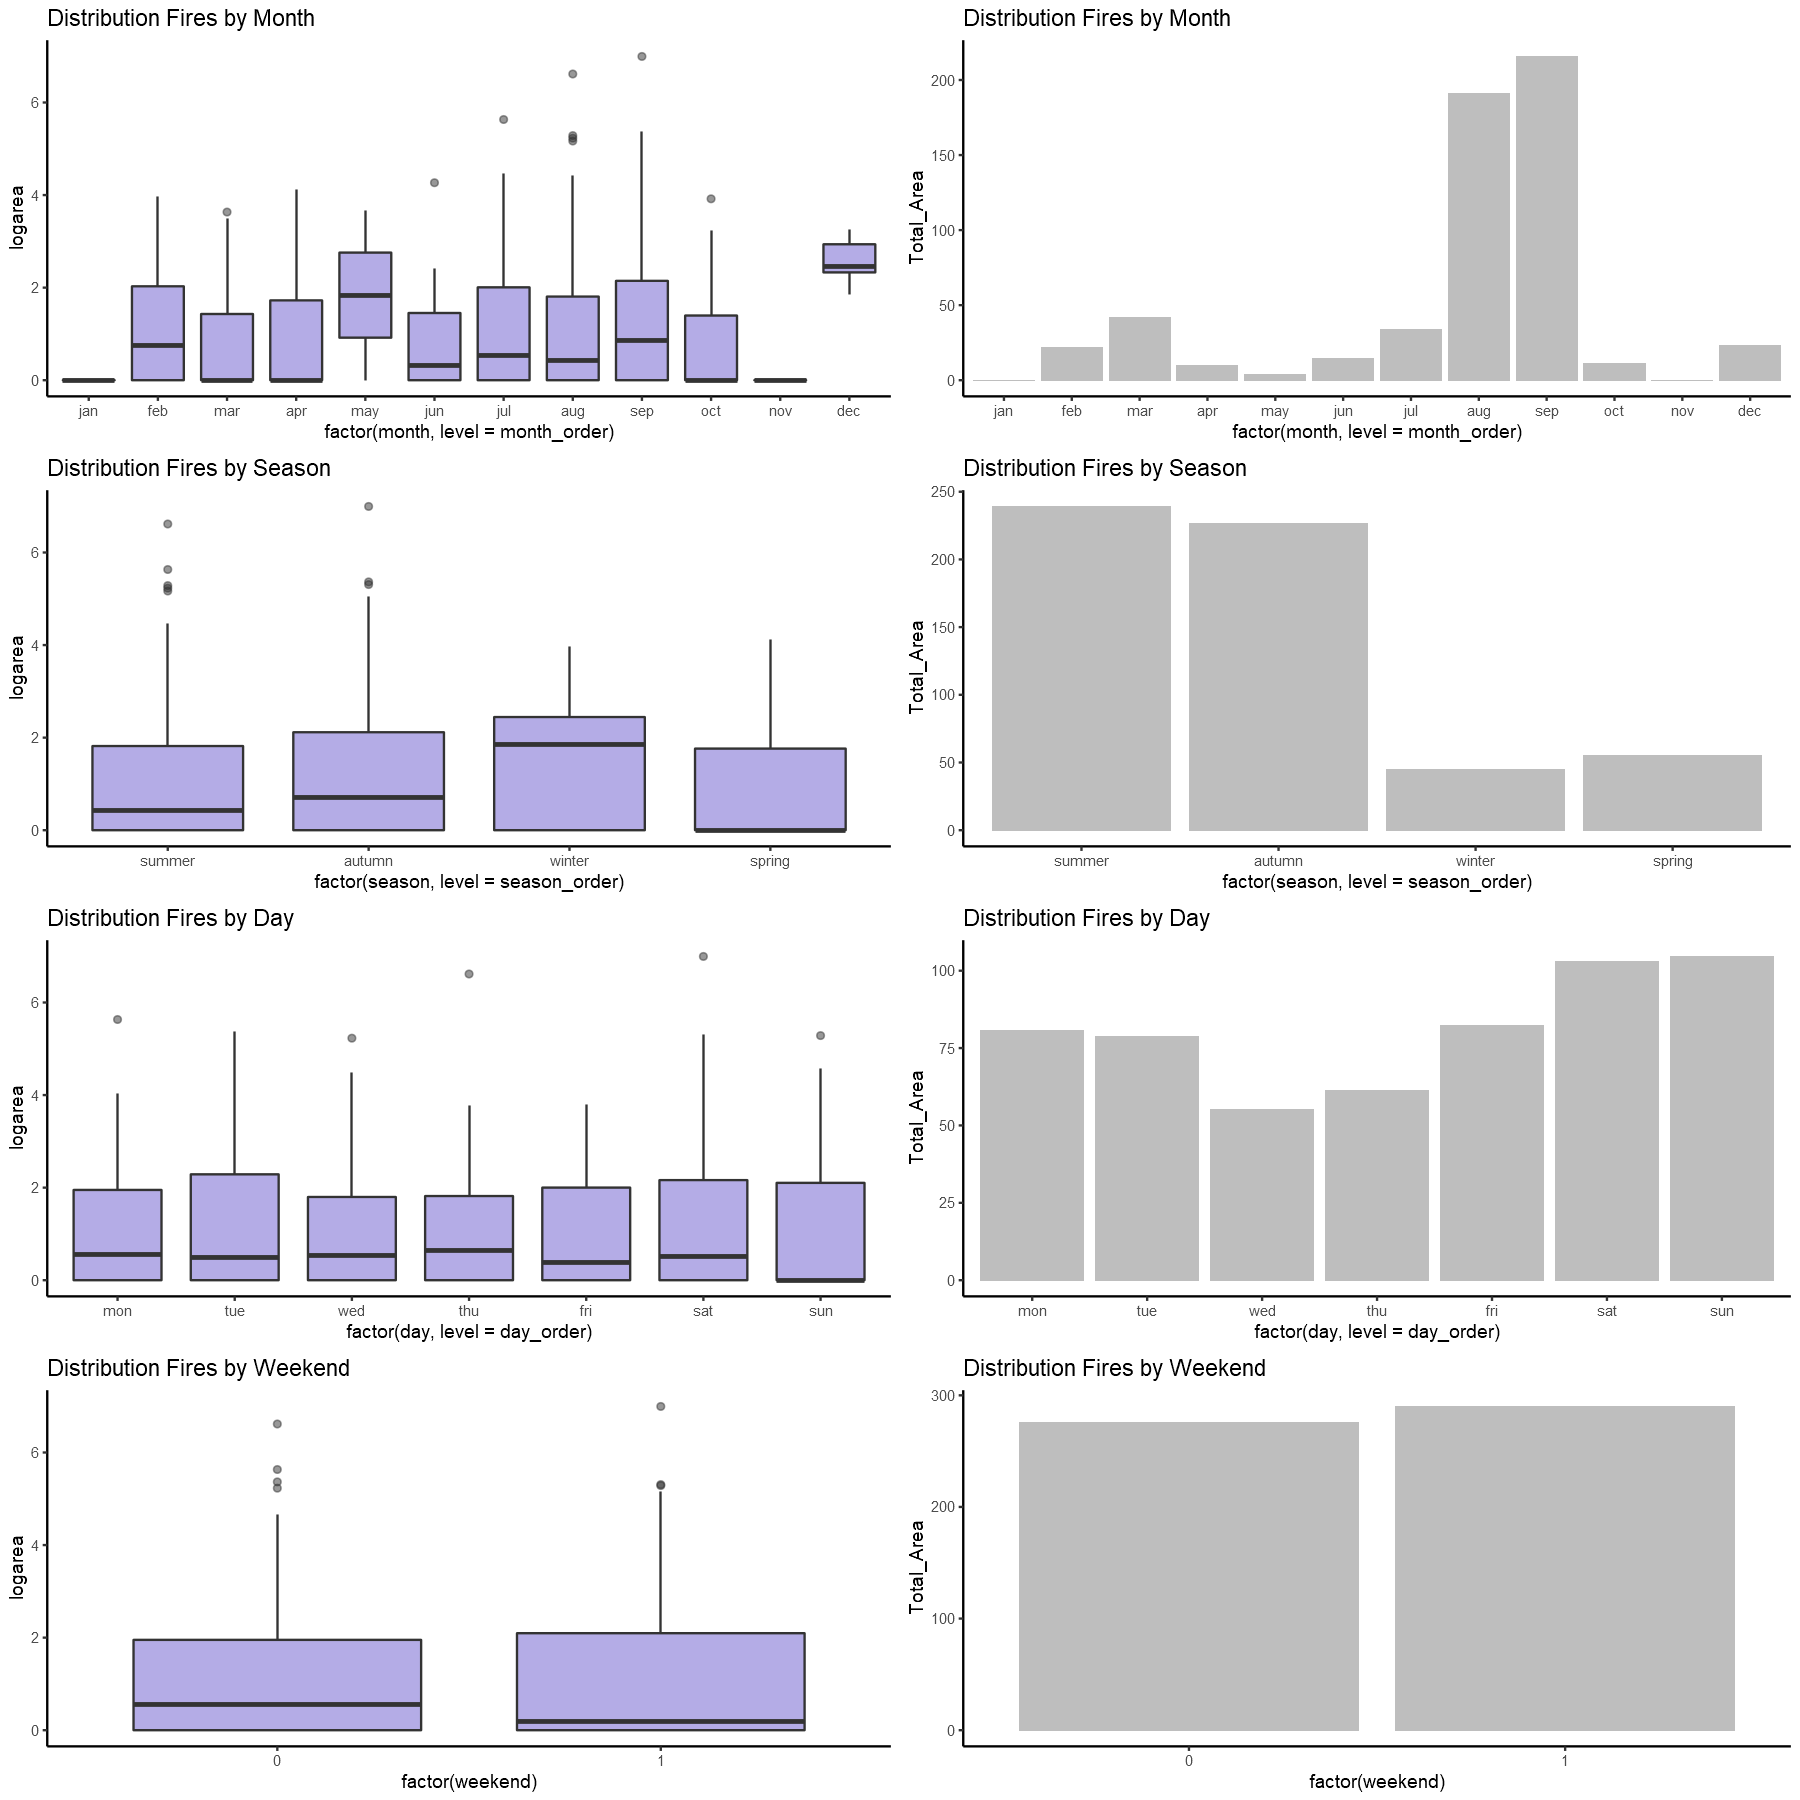

In [72]:
options(repr.plot.width=15, repr.plot.height=15) # managing the size
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, nrow = 4, ncol = 2) # making the plot

Some observations about the temporal data.

1. As expected summer has the highest number of fires, as we have seen that temperature is correlated to number of fires. 
2. Winter has a very small of fires compared to other seasons, but curiously the highest median. 
3. More than 70% of fires are either in summer or autumn. We expect this predictor to have a significant prediction power and we will create dummy variables for each season.
4. We are considering weekends with 3 days and weekdays of 4 days. Nevertheless there are more fires in weekends. This might demonstrate a relationship of fires with human activity. This is especially true if we consider that there are many significant fire outliers on weekends.  


####  One Hot Encoding of Seasons
To work with seasons it will be preferable to create dummy variables. This is what we will do next.

In [70]:
seasons <- unique(df_fires$season) 

for(i in (seasons)){
    df_fires[,paste0("season", i)] <- ifelse(test = df_fires$season == i, yes = 1, no = 0)
}

df_fires <- subset(df_fires, select = -c(seasonspring)) # eliminating a season for the one_hot_encoding 


### A first look at correlations
Lets investigate how the variables relate to each other. To explore correlations we will leave the previously explored variables - related to temporal and and spatial analysis.

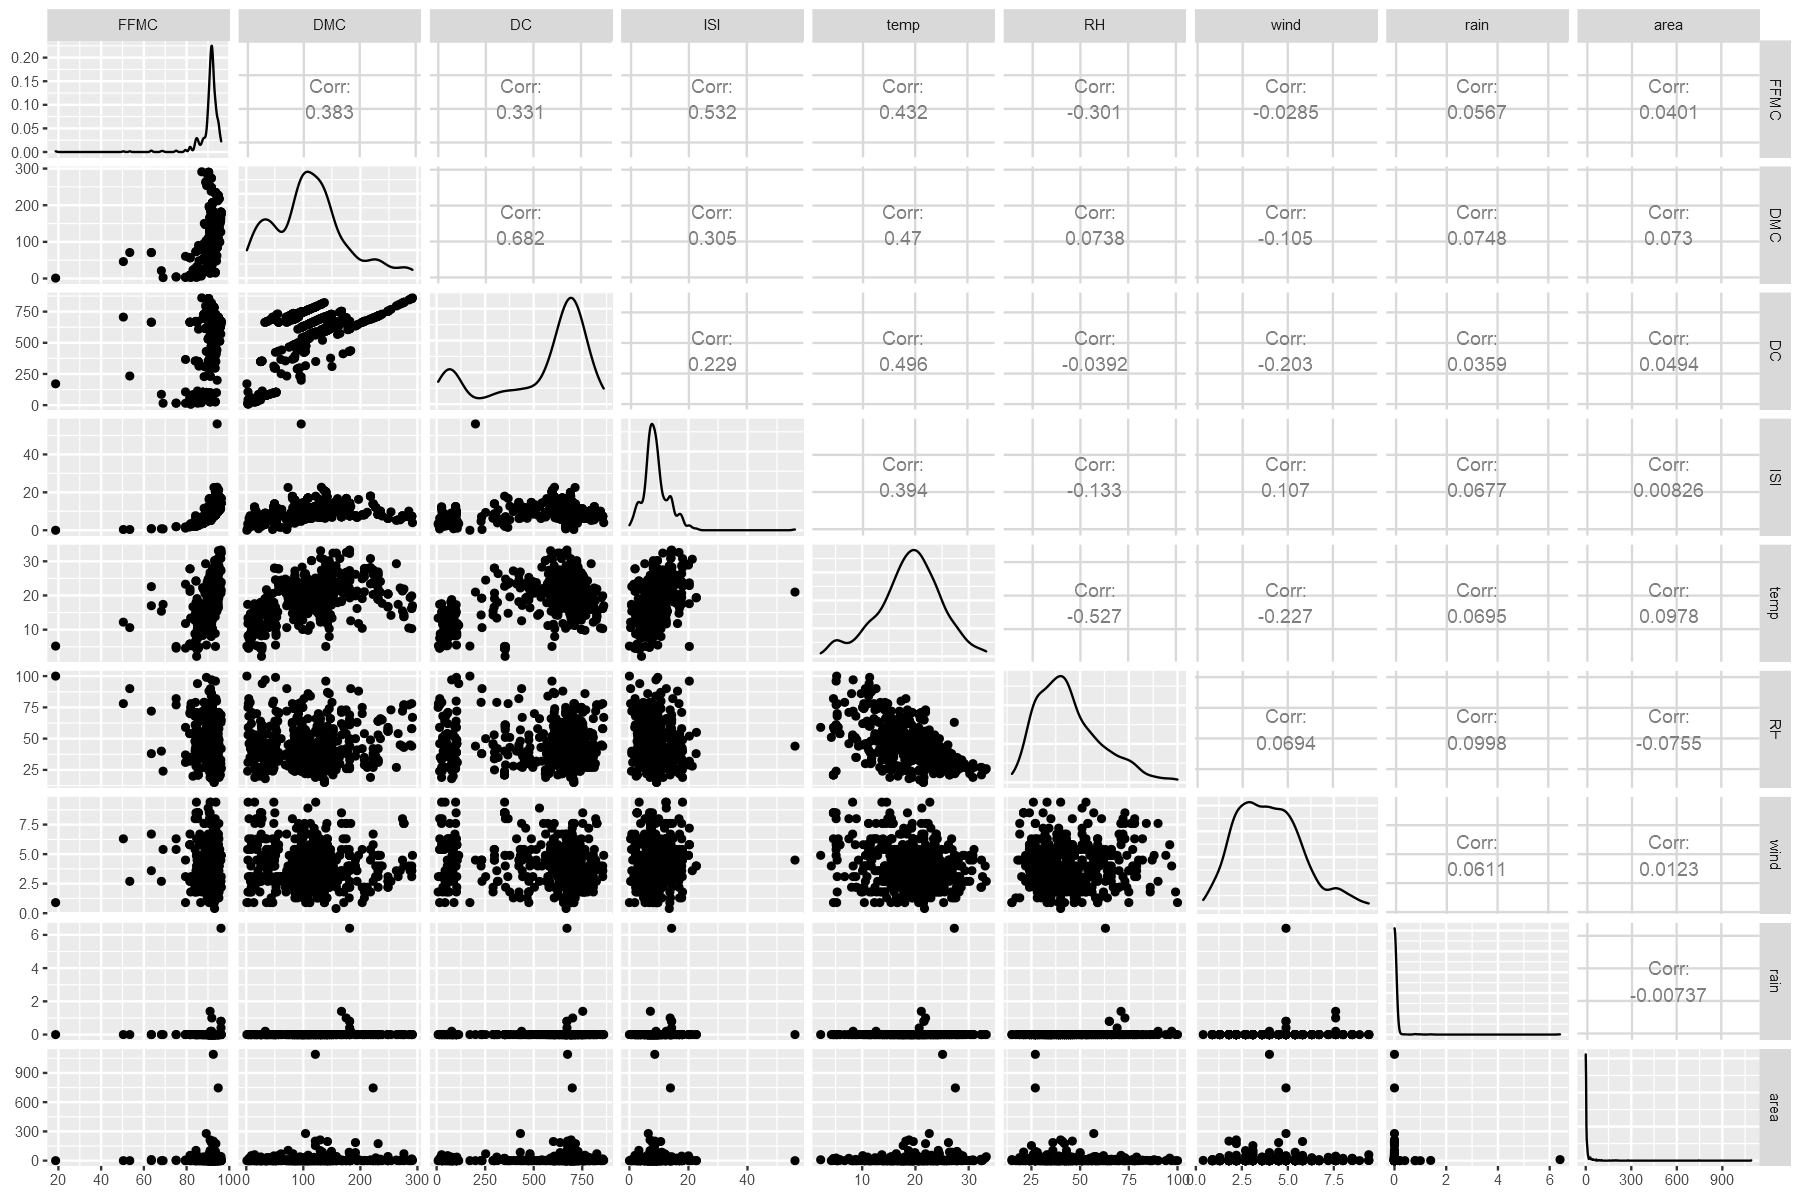

In [20]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size
ggpairs(df_fires[,c(seq(5,13))])

This chart is particularly useful as other than the correlation we can see the distribution of the variables. With respect to correlation:
- There is no significant and strong correlation with two variables.
    - Only one exception should be noticed, DC and DMC. **They might be useful working together in our models**. 
- Temp apparently have a meaningful but small positive correlation with ISI, DC, DMC and FFMC.
- Even though many of the variables have been extracted from other variables, as an example, DC from rain and temperature, our variables seem to have a good level of independence that allow us to work with them together with no major concerns with colinearity and similar problems.


## 3. Model Development<a class="anchor" id="sec_3"></a>

We will develop 2-3 models in this part of the project, with goal of predicting the burned area. Before performaing any modelling task, however, we will split the data in trainning and testing. Naturally, will we use a cross-validation approach. We will split the dataset in train and test, having 80% of trainning data.  

#### split Dataset in train and test

In [21]:
set.seed(210)
n <- nrow(df_fires)
shuffled <- df_fires[sample(n),]
df_train_fires <- shuffled[1:round(0.80 * n),]
df_test_fires <- shuffled[(round(0.80 * n) + 1):n,]
rownames(df_train_fires) <- 1:nrow(df_train_fires) 

#### Influential Outliers Detection
We have observed that the dataset has a right skewed distribution, and with significant outliers that may compromise our models. In this project we want to apply exclusevely linear models along with logistic regressions and therefore we would benefit from a clean dataset. Therefore we will remove significant outliers from our dataset. There are two recommended approaches in this situation:
- Remove outliers according to boxplot distribution.
- Remove Influential points according to Cooks distance. 

We have decided to take the second approach as we believe it is more aligned with the scope of our project and regression models. We will do it by the following steps.

1. Filter from the dataset all non-zero area points. We want to do it because we will build some models that will target the non-zero distribution of the area. 
2. Build a simple linear regression with all predictors.
3. Find influential points.
4. Remove influential points from the dataset.

Obs: The method used in this extraction was influenced by the following [work](http://www.columbia.edu/~yh2693/ForestFire.html).

In [22]:
attach(df_train_fires)
posit_data <- df_train_fires[which(area > 0),]

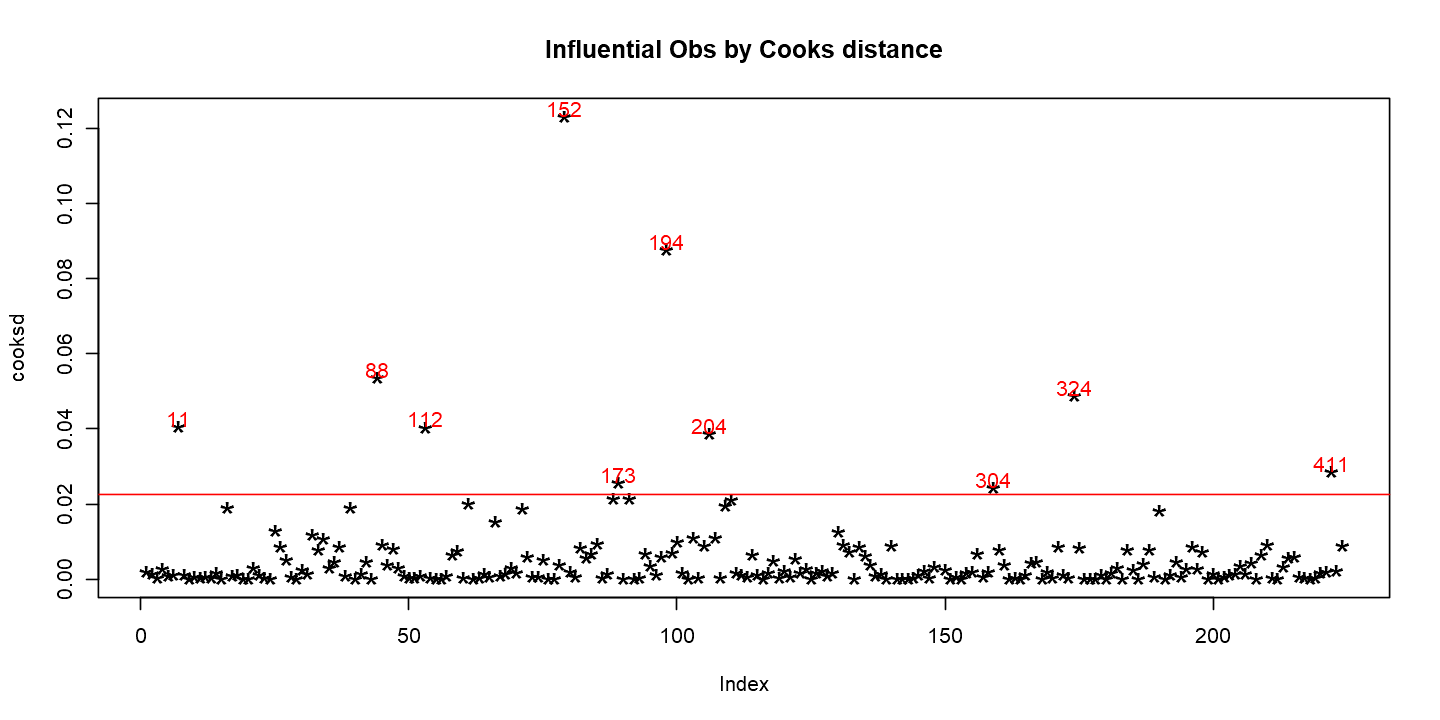

In [23]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size

mod <- lm(logarea ~ ., data=posit_data[c(seq(1,12),seq(14,31))]) # regression model
cooksd <- cooks.distance(mod)

options(repr.plot.width=12, repr.plot.height=6) # managing the size
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd), y=cooksd+0.002, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [24]:
influential = which(cooksd>4*mean(cooksd, na.rm=T)) # finding influential points
df_train_fires[as.numeric(names(influential)), 1:13] 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
11,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0,185.76
88,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0,278.53
112,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0,746.28
152,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,0.71
173,7,4,aug,sat,93.5,139.4,594.2,20.3,5.1,96,5.8,0,26.00
194,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0,212.88
204,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0,1090.84
304,4,3,aug,wed,94.5,139.4,689.1,20.0,28.9,29,4.9,0,49.59
324,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36


In [25]:
df_fires = df_fires[-as.numeric(names(influential)), ] # removing from the dataset

## Model 1 - Linear Regression

Our first model will be a simple linear regression. <br>
We have observed that the area is not normally distributed and therefore it is preferable to predict the log of area. Nevertheless, we will also test a model to predict the area. As we know, the formula of the regression is: <br>

**First Model:** $ y = \beta_0 + \beta_1 * x_1 + ... + \beta_n * x_n$ <br>
**Second Model:** $ log(y) = \beta_0 + \beta_1 * x_1 + ... + \beta_n * x_n$ 


When fitting a regression we want to obtain the best performance of our metrics. The most relevant are:
- R-Squared: Represents the proportion of the variance for a dependent variable that's explained by independent variables. The higher the better.
- Adjusted R-squared: Simillar to R-squared, but also compares the explanatory power of regression models that contain different numbers of predictors. The higher the better.
- F-Test: Indicates if the model provides a better fit to the data than a model that contains no independent variables. The higher the better.
- RMSE: Represents the standard deviation of the differences between predicted values and observed values (residuals). The lower the better.


In [26]:
names(df_train_fires)

[1] "X"            "Y"            "month"        "day"          "FFMC"        
 [6] "DMC"          "DC"           "ISI"          "temp"         "RH"          
[11] "wind"         "rain"         "area"         "logarea"      "Region"      
[16] "Region1"      "Region3"      "Region4"      "Region11"     "Region19"    
[21] "Region20"     "Region42"     "Region43"     "Region52"     "Region53"    
[26] "Region58"     "Region59"     "Region60"     "Region65"     "Region67"    
[31] "season"       "weekend"      "seasonautumn" "seasonsummer" "seasonwinter"

We will create a list of the variables called predictors that will help us in the progress of our model development. Also a support function that will be used to have less wording in the model development. A important note: We will explore the sinergy of `DC` and `DMC` - as we saw in the previous section and they are strongly correlated.

In [27]:
# create a list of variables to use in modelling
predictors <- c("X", "Y", "FFMC", "DMC", "DMC:DC", "ISI", "temp", "RH", "wind", "rain", 
           "Region1", "Region3", "Region4", "Region11", "Region19", "Region20", "Region42", "Region43", 
                "Region52", "Region53", "Region58", "Region59","Region60", "Region65", "weekend",
                "seasonautumn", "seasonwinter", "seasonsummer")

simplify <- function(y, predictors){
  return(as.formula(paste(y, "~", paste(predictors, collapse = "+"))))
}

In [28]:
# Fitting the models 

lm_area <- lm(simplify("area", predictors), data = df_train_fires) 
lm_logarea <- lm(simplify("logarea", predictors), data = df_train_fires) 

# summary of the model (estimates and metrics)
summary(lm_area)
summary(lm_logarea)


Call:
lm(formula = simplify("area", predictors), data = df_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
 -60.70  -20.82   -6.98    5.01 1024.21 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -5.768e+01  8.366e+01  -0.690   0.4909  
X             3.379e+00  3.696e+00   0.914   0.3612  
Y            -4.351e-01  6.178e+00  -0.070   0.9439  
FFMC         -7.792e-02  8.029e-01  -0.097   0.9227  
DMC           7.302e-01  3.462e-01   2.110   0.0355 *
ISI          -7.071e-01  9.687e-01  -0.730   0.4659  
temp          1.939e+00  1.217e+00   1.594   0.1118  
RH           -9.880e-02  3.435e-01  -0.288   0.7738  
wind          2.720e+00  2.184e+00   1.245   0.2139  
rain         -2.418e+00  1.158e+01  -0.209   0.8347  
Region1       1.338e+01  2.543e+01   0.526   0.5992  
Region3      -1.343e+00  1.610e+01  -0.083   0.9335  
Region4       1.998e+00  1.835e+01   0.109   0.9134  
Region11      4.730e-01  1.989e+01   0.024   0.9810  
Region19


Call:
lm(formula = simplify("logarea", predictors), data = df_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1635 -0.9899 -0.4054  0.7261  5.1428 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -8.455e-01  1.646e+00  -0.514  0.60766   
X             1.569e-01  7.271e-02   2.158  0.03154 * 
Y            -2.417e-01  1.215e-01  -1.989  0.04740 * 
FFMC          1.281e-02  1.579e-02   0.811  0.41774   
DMC           1.453e-02  6.809e-03   2.134  0.03345 * 
ISI          -1.574e-02  1.905e-02  -0.826  0.40937   
temp          3.150e-02  2.393e-02   1.316  0.18881   
RH            2.656e-03  6.756e-03   0.393  0.69447   
wind          9.700e-02  4.297e-02   2.258  0.02453 * 
rain          1.291e-01  2.277e-01   0.567  0.57099   
Region1      -8.881e-01  5.002e-01  -1.775  0.07663 . 
Region3      -6.338e-01  3.166e-01  -2.002  0.04599 * 
Region4      -3.222e-01  3.610e-01  -0.893  0.37260   
Region11      1.459e-01  3.913e-01   0.373  0

As expected `lm_logarea` performed better than `lm_area`, because logarea is more appropriate as a label. Therefore we will be working exclusevely with lm_logarea from now on. It calls our attention that the model has a small predictive power with respect to the metrics of performance, such as F-statistic and R-squared. In fact we found an negative adjusted R-Squared in `lm_area` which means the model contains terms that do not help to predict the response. Let's proceed with diagnostic plots.

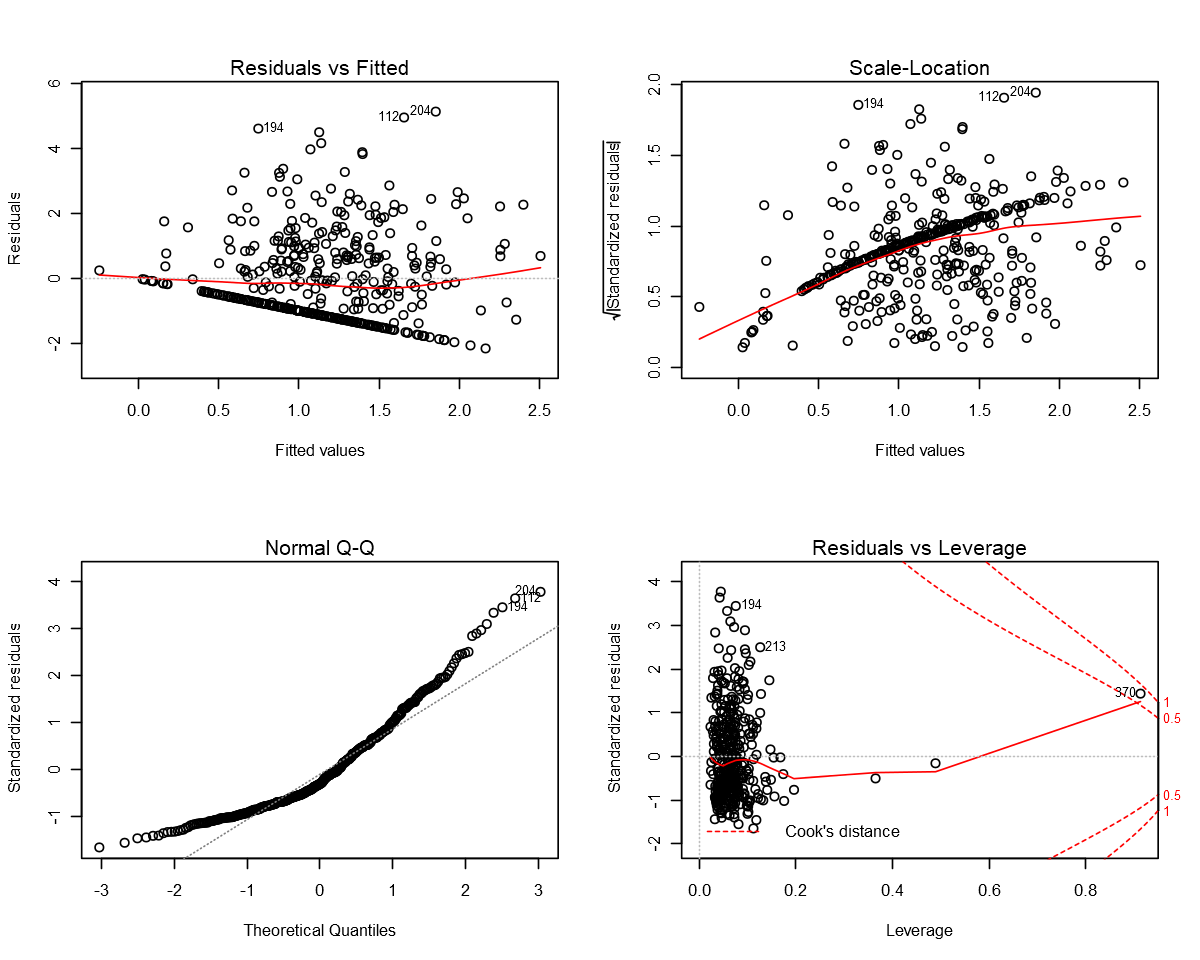

In [29]:
options(repr.plot.width=10, repr.plot.height=8) # managing the size
par(mfcol=c(2,2))
plot(lm_logarea)

The diagnostic plots show residuals in four different ways. Some observations about the plots:

- **Residual vs fitted plot and scale-location plot:**  They access if the residuals have non-linear patterns and if residuals are spread equally along the ranges of predictors. We can see an abnormal pattern such as some points in a linear trend. Other points are well behaved.
- **Q-Q plot:** Unfortunately we can observe that the distribution of the residuals is not normal and this might explain the performance of our model. 
- **Residual-leverage plot**: Since we have previously performed data manipulation removing outliers and highly influential points, they are not a concern in this step. There is a limitrofe point just on the 0.5 line but we will keep it for now.


### Subset Selection

In this task, we will use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors. We want the best model obtained according to $C_p$, $BIC$, and adjusted $R^2$. Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained.

In [30]:
lm_subset <- regsubsets(simplify("logarea", predictors), data = df_train_fires, nvmax = 40)
lm_subset.summary <- summary(lm_subset)
lm_subset.summary

Subset selection object
Call: regsubsets.formula(simplify("logarea", predictors), data = df_train_fires, 
    nvmax = 40)
28 Variables  (and intercept)
             Forced in Forced out
X                FALSE      FALSE
Y                FALSE      FALSE
FFMC             FALSE      FALSE
DMC              FALSE      FALSE
ISI              FALSE      FALSE
temp             FALSE      FALSE
RH               FALSE      FALSE
wind             FALSE      FALSE
rain             FALSE      FALSE
Region1          FALSE      FALSE
Region3          FALSE      FALSE
Region4          FALSE      FALSE
Region11         FALSE      FALSE
Region19         FALSE      FALSE
Region20         FALSE      FALSE
Region42         FALSE      FALSE
Region43         FALSE      FALSE
Region52         FALSE      FALSE
Region53         FALSE      FALSE
Region58         FALSE      FALSE
Region59         FALSE      FALSE
Region60         FALSE      FALSE
Region65         FALSE      FALSE
weekend          FALSE      FALS

Due to the fact we have created many dummy variables for geographic region, our model may have up to 40 variables. We have found the best subset for n variables, when n ranges from 1 to 30. Now we will plot the number of variables from the best models against the accuracy indicators such as Cp, BIC, Ajusted R-squared and RSS.

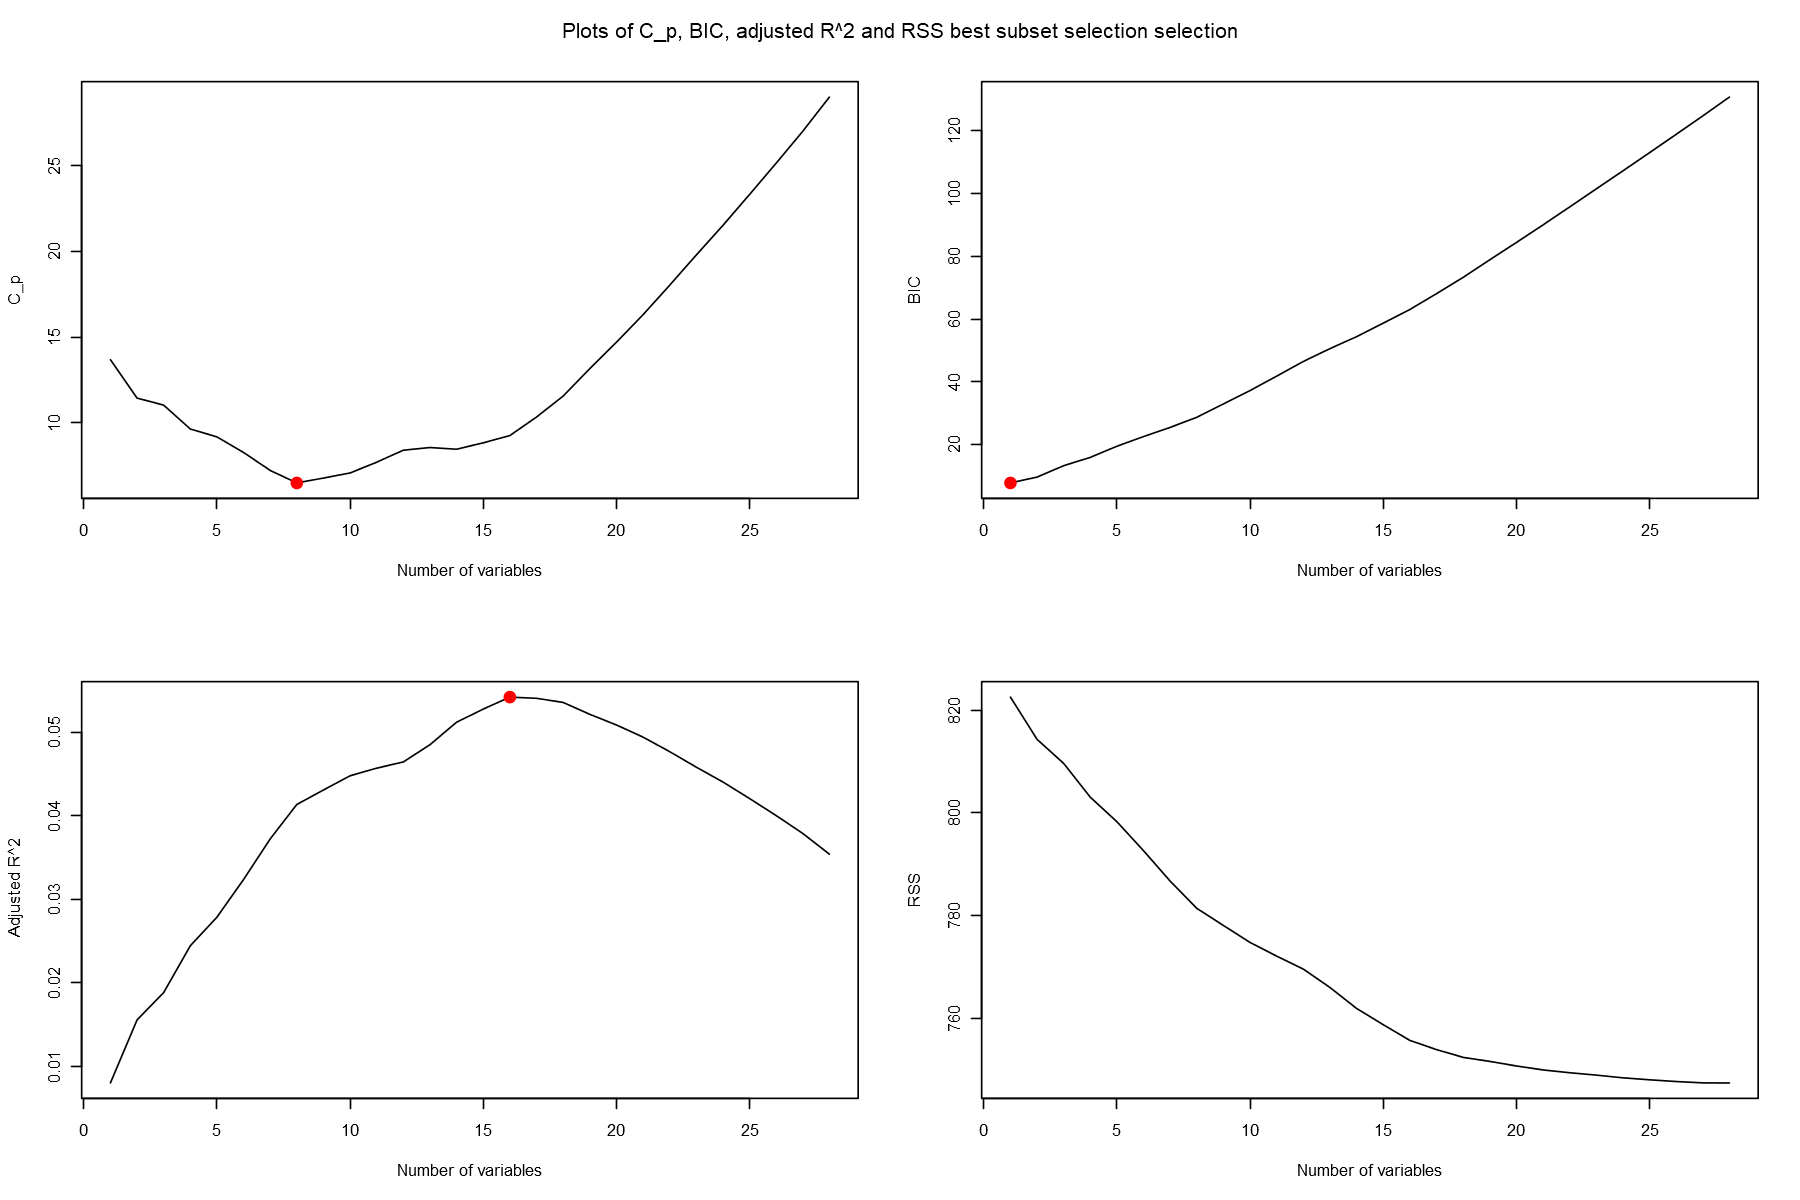

In [31]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size
par(mfrow = c(2, 2))
plot(lm_subset.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(lm_subset.summary$cp), lm_subset.summary$cp[which.min(lm_subset.summary$cp)], col = "red", cex = 2, pch = 20)
plot(lm_subset.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(lm_subset.summary$bic), lm_subset.summary$bic[which.min(lm_subset.summary$bic)], col = "red", cex = 2, pch = 20)
plot(lm_subset.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(lm_subset.summary$adjr2), lm_subset.summary$adjr2[which.max(lm_subset.summary$adjr2)], col = "red", cex = 2, pch = 20)
plot(lm_subset.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS best subset selection selection", side = 3, line = -2, outer = TRUE)

It is interesting the fact that we have found different models according to each indicator. Lets compare then.

In [32]:
coef(lm_subset, which.min(lm_subset.summary$cp))
coef(lm_subset, which.min(lm_subset.summary$bic))
coef(lm_subset, which.max(lm_subset.summary$adjr2))

(Intercept)           DMC          temp          wind       Region1 
-2.661170e-02  1.351112e-02  3.013579e-02  7.942345e-02 -6.521298e-01 
      Region3  seasonwinter  seasonsummer        DMC:DC 
-5.563615e-01  8.244370e-01 -6.258173e-01 -1.271263e-05

(Intercept)     Region3 
  1.1908328  -0.5499213

(Intercept)             X             Y           DMC          temp 
 5.519830e-01  9.261658e-02 -1.944049e-01  1.367023e-02  3.053126e-02 
         wind       Region1       Region3       Region4      Region42 
 8.391994e-02 -9.686413e-01 -6.792726e-01 -4.165768e-01 -9.109324e-01 
     Region43      Region52      Region59      Region65  seasonwinter 
-6.684939e-01 -6.063462e-01 -7.188131e-01 -6.422480e-01  9.902422e-01 
 seasonsummer        DMC:DC 
-6.914476e-01 -1.233128e-05

Observations from the subset selection:
- While $C_P$ indicates a total of 9 predictors, $BIC$ indicates only one. Adjusted-R-squared indicates 18 variables. 
- We will reject the BIC analysis as we do not believe the model will have a good fit in the test data and work exclusevely with the second and third models.

In [33]:
# create variables
predictors_cp <- c('DMC','temp','wind', 'Region1', 'Region3','seasonwinter', 'seasonsummer', 'DMC:DC')
predictors_adjR <- c('X', 'Y', 'DMC', 'temp', 'wind', 'Region1', 'Region3', 'Region4', 'Region42',
                     'Region43', 'Region52', 'Region59', 'Region65','seasonwinter', 'seasonsummer', 'DMC:DC')

lm_cp_logarea <- lm(simplify("logarea", predictors_cp), data = df_train_fires) 
lm_adjR2_logarea <- lm(simplify("logarea", predictors_adjR), data = df_train_fires) 

summary(lm_cp_logarea)
summary(lm_adjR2_logarea)


Call:
lm(formula = simplify("logarea", predictors_cp), data = df_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9576 -1.0736 -0.4319  0.8178  5.3502 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -2.661e-02  3.775e-01  -0.071  0.94383   
DMC           1.351e-02  6.282e-03   2.151  0.03208 * 
temp          3.014e-02  1.512e-02   1.993  0.04693 * 
wind          7.942e-02  4.035e-02   1.968  0.04972 * 
Region1      -6.521e-01  3.569e-01  -1.827  0.06841 . 
Region3      -5.564e-01  2.628e-01  -2.117  0.03484 * 
seasonwinter  8.244e-01  3.556e-01   2.318  0.02094 * 
seasonsummer -6.258e-01  2.088e-01  -2.998  0.00289 **
DMC:DC       -1.271e-05  7.052e-06  -1.803  0.07218 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.389 on 405 degrees of freedom
Multiple R-squared:  0.05992,	Adjusted R-squared:  0.04135 
F-statistic: 3.227 on 8 and 405 DF,  p-value: 0.001433



Call:
lm(formula = simplify("logarea", predictors_adjR), data = df_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0490 -1.0297 -0.3824  0.7927  5.1096 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   5.520e-01  5.484e-01   1.007  0.31475   
X             9.262e-02  4.557e-02   2.033  0.04276 * 
Y            -1.944e-01  9.841e-02  -1.975  0.04891 * 
DMC           1.367e-02  6.285e-03   2.175  0.03022 * 
temp          3.053e-02  1.523e-02   2.005  0.04566 * 
wind          8.392e-02  4.036e-02   2.079  0.03825 * 
Region1      -9.686e-01  4.217e-01  -2.297  0.02213 * 
Region3      -6.793e-01  2.770e-01  -2.453  0.01461 * 
Region4      -4.166e-01  3.287e-01  -1.268  0.20571   
Region42     -9.109e-01  3.850e-01  -2.366  0.01846 * 
Region43     -6.685e-01  2.844e-01  -2.350  0.01924 * 
Region52     -6.063e-01  4.564e-01  -1.329  0.18476   
Region59     -7.188e-01  3.268e-01  -2.200  0.02842 * 
Region65     -6.422e-01  3.961e-01  -1.6

Apparently, `lm_adjR2_logarea` is the best performing model and therefore the winner of this first part. We arrived to this conclusion according to the F-statistic and the adjusted R-squared. Lets plot the residuals of the model.

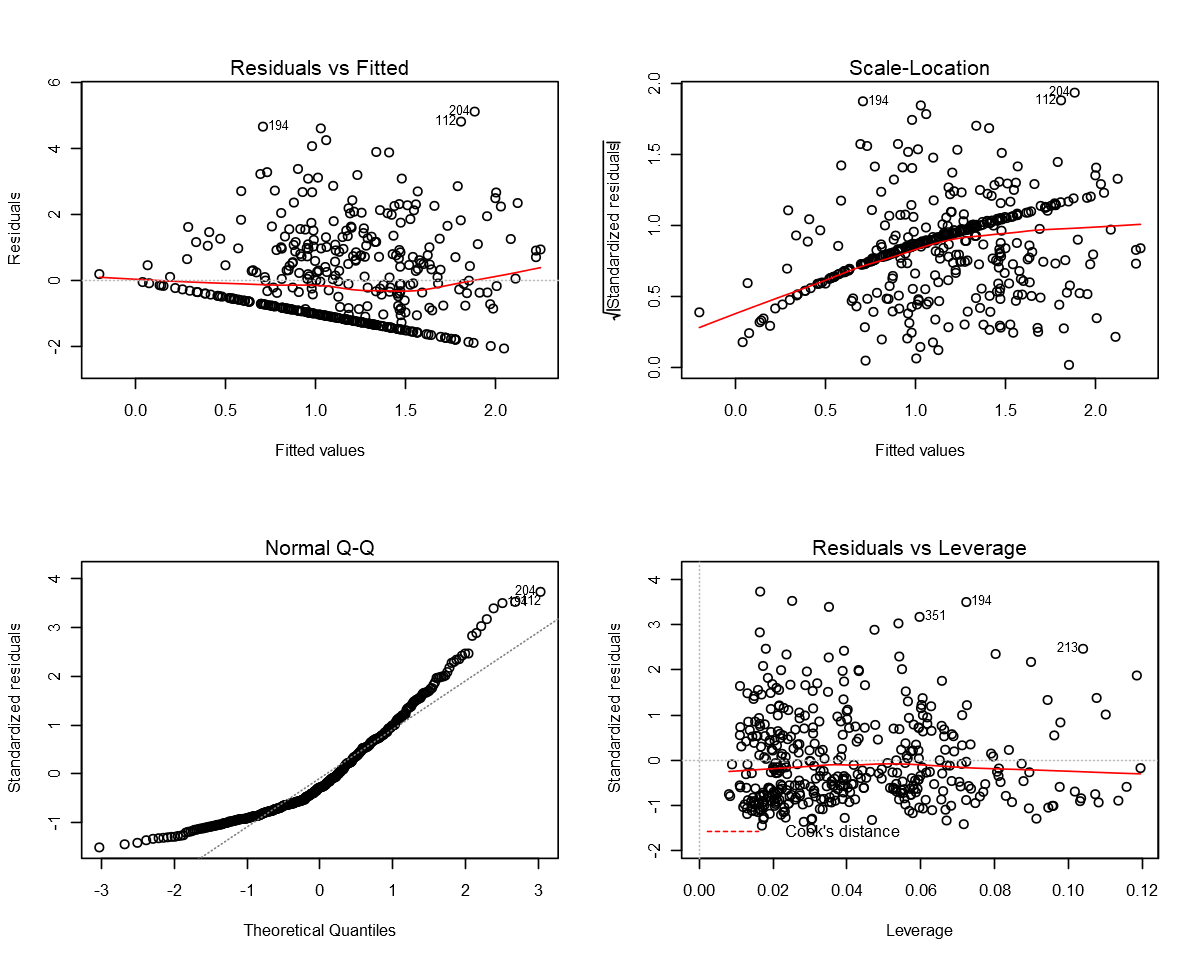

In [34]:
options(repr.plot.width=10, repr.plot.height=8) # managing the size
par(mfcol=c(2,2))
plot(lm_adjR2_logarea)

We can see that many of the problems of the first model persist. Lets make an anova analysis.

In [35]:
anova(lm_logarea, lm_adjR2_logarea)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,385,747.4043,NA,NA,NA,NA
2,397,755.6820,-12,-8.277686,0.3553308,0.9774972


P-value is high and therefore we cannot affirm with certainty that there was an improvment in the model. It makes sense according to our previous plots. 

## Second Model - Classification + Regression

In our second model we will join a classification step to our model with the goal to split the dataset in fires that ~ 0 area burned and fires with more significant area burned. We follow the approach from [Yanghe Huo](http://www.columbia.edu/~yh2693/#reference). As we have seen in the data exploration the significant fires (more than 0) follow a normal distribution (closely). Therefore we have an expectation to be able to perform an improved analysis in this second model. Our model can be decribed as the following:

**Model:** $ E[Y|X]=Pr(Y>0|X)×E(Y|Y>0,X)$, where <br>

- First Component: $Pr(Y>0|X)$ is a classification model that aims to identify observations with 0 area burned.
- Second Component: $E(Y|Y>0,X)$ is a regression model that aims to estimate all area burned of all points that are different than 0.

As we have observed, it is prefered to work with the logarea as it has a more well behaved distribution. Once we remove the points that are equal to 0 than we have almost a normal distribution, which is preferable when performing a regression. Again lets observe the distribution of the points > 0.

#### Logarea Burned area Distribution (>0)

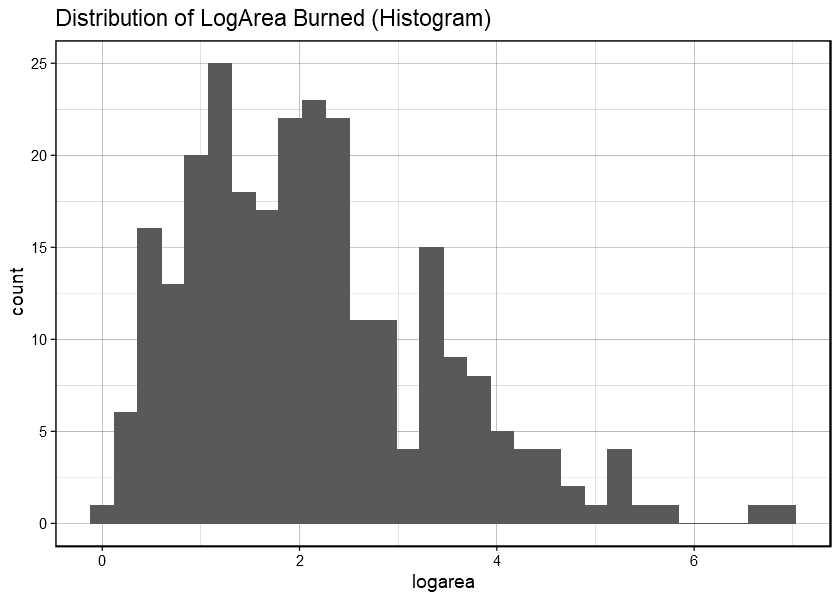

In [36]:
options(repr.plot.width = 7, repr.plot.height = 5) # managing the size
ggplot(df_fires[df_fires$logarea!= 0,], aes(logarea)) + geom_histogram(bins = 30) + 
theme_linedraw() + ggtitle("Distribution of LogArea Burned (Histogram)")

#### Creating a binary variable for classification

In [37]:
df_train_fires$binary_area <- ifelse(df_train_fires$area == 0, 0, 1)
df_test_fires$binary_area <- ifelse(df_test_fires$area == 0, 0, 1)

#### First Component: Binomial Regression

In [38]:
# part 1
lr_area <- glm(simplify("binary_area", predictors), data = df_train_fires, family = binomial())          
summary(lr_area)


Call:
glm(formula = simplify("binary_area", predictors), family = binomial(), 
    data = df_train_fires)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8324  -1.1165   0.7112   1.0218   1.9726  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)  -5.251e+00  3.020e+00  -1.739  0.08206 . 
X             1.893e-01  1.158e-01   1.636  0.10193   
Y            -3.358e-01  1.892e-01  -1.775  0.07598 . 
FFMC          4.757e-02  3.074e-02   1.547  0.12176   
DMC          -1.199e-03  1.056e-02  -0.114  0.90959   
ISI          -5.425e-03  2.993e-02  -0.181  0.85615   
temp          4.970e-02  3.709e-02   1.340  0.18028   
RH            8.133e-03  1.053e-02   0.773  0.43970   
wind          1.526e-01  6.831e-02   2.234  0.02546 * 
rain          2.433e-01  3.856e-01   0.631  0.52806   
Region1      -2.061e+00  8.422e-01  -2.447  0.01441 * 
Region3      -8.628e-01  4.813e-01  -1.793  0.07303 . 
Region4      -7.284e-01  5.524e-01  -1.318  0.187

We have found some relevant variables in the task of predicting if an area had more than 0 area burned, notably specific  variables linked to regions and seasons. We will now use the variables selected in part 1 to perform the logistic regression. We will not go through a process of subset selection variables because we expect the outcome to be the same due to math propoerties that are not relevant to this work. 


In [39]:
lr_adjR2_area <- glm(simplify("binary_area", predictors_adjR), data = df_train_fires, family = binomial())          
summary(lr_adjR2_area)


Call:
glm(formula = simplify("binary_area", predictors_adjR), family = binomial(), 
    data = df_train_fires)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7681  -1.1746   0.7446   1.0195   1.9581  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)  -1.323e-01  8.357e-01  -0.158  0.87420   
X             6.577e-02  6.959e-02   0.945  0.34463   
Y            -2.391e-01  1.517e-01  -1.576  0.11504   
DMC          -1.143e-03  9.553e-03  -0.120  0.90480   
temp          4.227e-02  2.347e-02   1.801  0.07169 . 
wind          1.306e-01  6.339e-02   2.061  0.03930 * 
Region1      -2.429e+00  7.469e-01  -3.252  0.00114 **
Region3      -1.188e+00  4.247e-01  -2.797  0.00515 **
Region4      -1.127e+00  5.061e-01  -2.228  0.02590 * 
Region42     -1.511e+00  5.871e-01  -2.574  0.01004 * 
Region43     -5.675e-01  4.318e-01  -1.314  0.18873   
Region52     -1.528e+00  7.278e-01  -2.099  0.03582 * 
Region59     -3.943e-01  4.981e-01  -0.792  

As expected, since we have reduceded the number of predictors, the Residual deviance had an slight increase. On the other hand, the AIC had a decrease. This indicates the model is now less prone to overffiting, and more likely to have a good performance in the test data. Now we will continue with a regression on the positive points of the dataset.  

In [40]:
df_posit_train_fires <- df_train_fires[df_train_fires$area > 0,]
lm_posit_logarea <- lm(simplify("logarea", predictors), data = df_posit_train_fires)
summary(lm_posit_logarea)


Call:
lm(formula = simplify("logarea", predictors), data = df_posit_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3215 -0.8083 -0.1362  0.5900  4.3011 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   1.973e+00  3.588e+00   0.550  0.58306   
X             1.104e-01  7.819e-02   1.411  0.15973   
Y            -8.190e-02  1.398e-01  -0.586  0.55873   
FFMC         -1.589e-02  3.888e-02  -0.409  0.68310   
DMC           2.582e-02  8.727e-03   2.959  0.00347 **
ISI          -2.199e-02  3.205e-02  -0.686  0.49338   
temp          3.863e-02  3.109e-02   1.242  0.21558   
RH            3.408e-03  9.110e-03   0.374  0.70873   
wind          8.164e-02  5.605e-02   1.457  0.14684   
rain         -1.474e-01  2.427e-01  -0.607  0.54434   
Region1       8.466e-01  8.488e-01   0.997  0.31976   
Region3      -4.940e-01  4.419e-01  -1.118  0.26493   
Region4       3.612e-01  5.263e-01   0.686  0.49335   
Region11     -1.780e-01  4.688e-01  -0.

The model has a quite low performance and we will apply subset selection to try to improve it.

In [41]:
lm_posit_subset <- regsubsets(simplify("logarea", predictors), data = df_posit_train_fires, nvmax = 40)
lm_posit_subset.summary <- summary(lm_posit_subset)
lm_posit_subset.summary

Subset selection object
Call: regsubsets.formula(simplify("logarea", predictors), data = df_posit_train_fires, 
    nvmax = 40)
28 Variables  (and intercept)
             Forced in Forced out
X                FALSE      FALSE
Y                FALSE      FALSE
FFMC             FALSE      FALSE
DMC              FALSE      FALSE
ISI              FALSE      FALSE
temp             FALSE      FALSE
RH               FALSE      FALSE
wind             FALSE      FALSE
rain             FALSE      FALSE
Region1          FALSE      FALSE
Region3          FALSE      FALSE
Region4          FALSE      FALSE
Region11         FALSE      FALSE
Region19         FALSE      FALSE
Region20         FALSE      FALSE
Region42         FALSE      FALSE
Region43         FALSE      FALSE
Region52         FALSE      FALSE
Region53         FALSE      FALSE
Region58         FALSE      FALSE
Region59         FALSE      FALSE
Region60         FALSE      FALSE
Region65         FALSE      FALSE
weekend          FALSE    

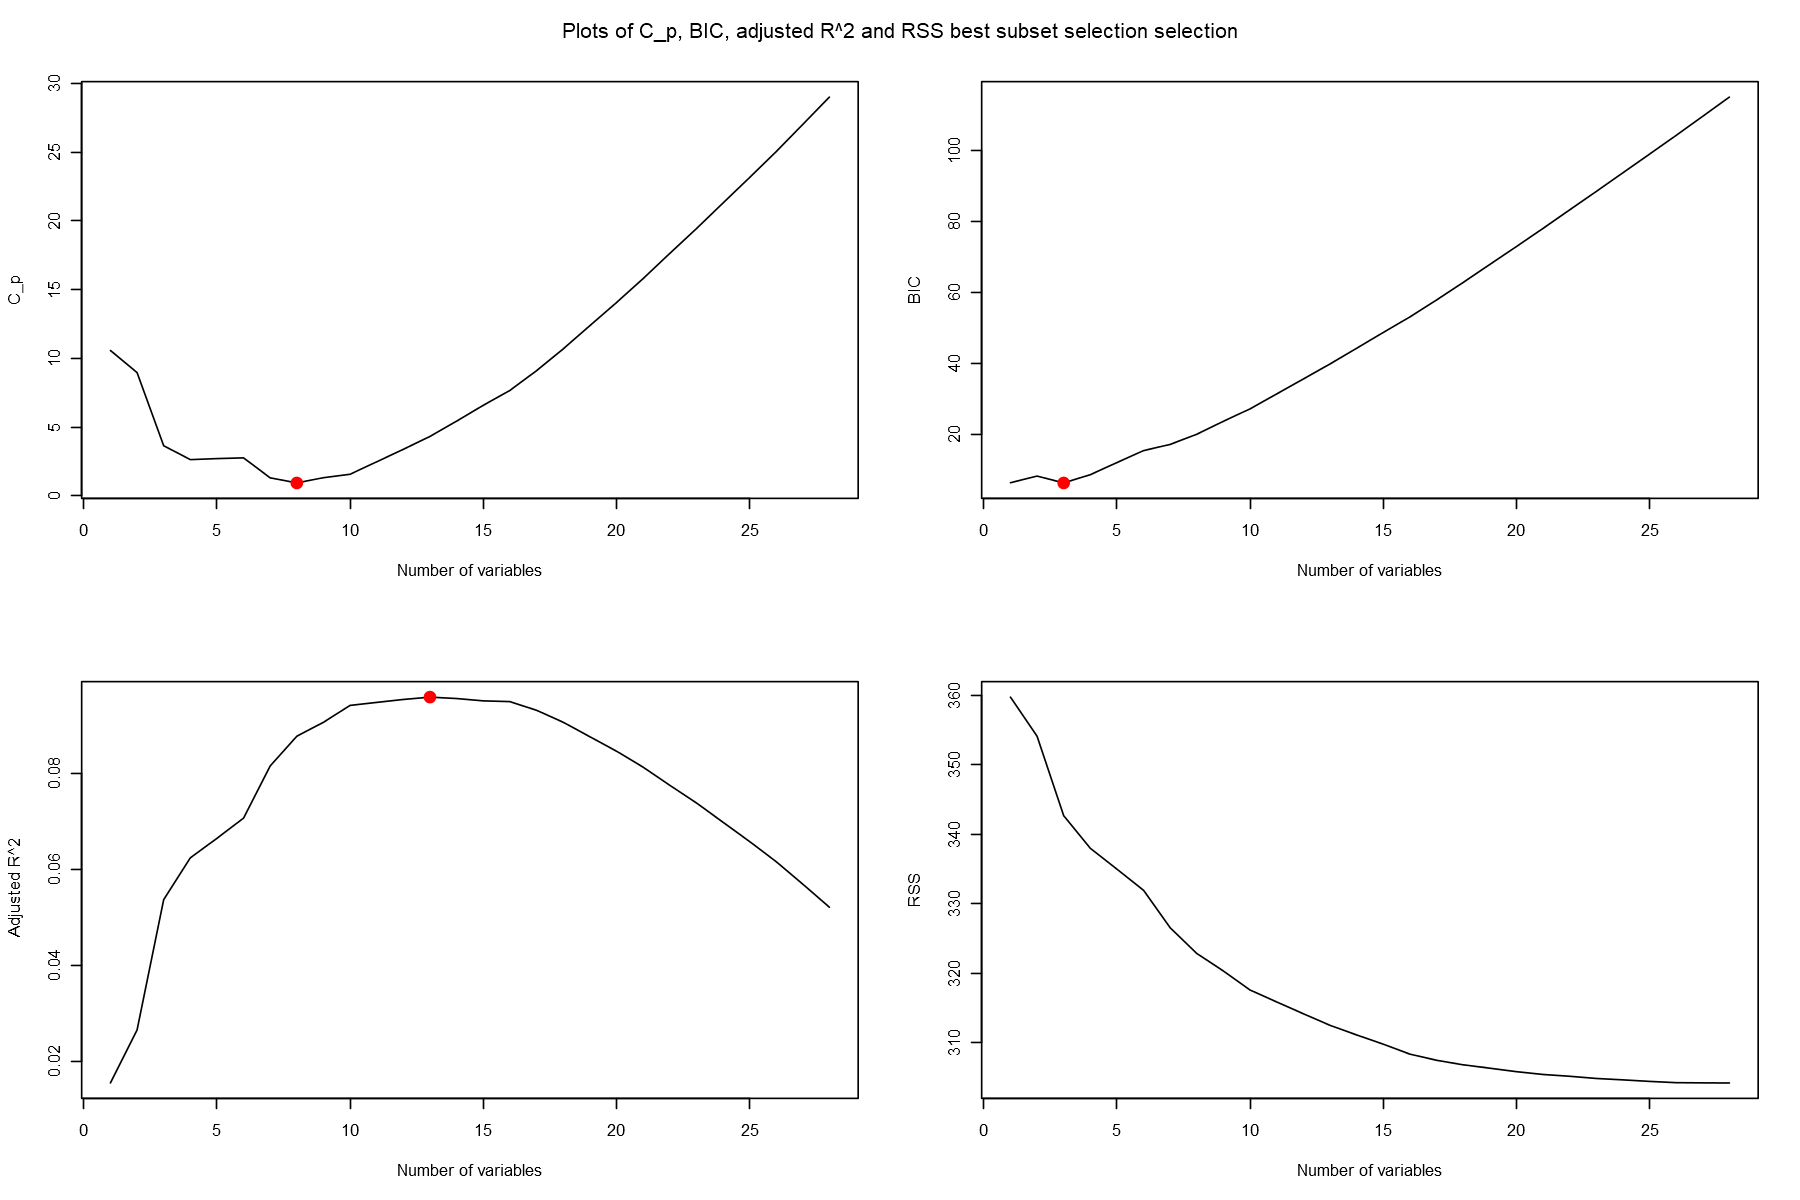

In [42]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size
par(mfrow = c(2, 2))
plot(lm_posit_subset.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(lm_posit_subset.summary$cp), lm_posit_subset.summary$cp[which.min(lm_posit_subset.summary$cp)], col = "red", cex = 2, pch = 20)
plot(lm_posit_subset.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(lm_posit_subset.summary$bic), lm_posit_subset.summary$bic[which.min(lm_posit_subset.summary$bic)], col = "red", cex = 2, pch = 20)
plot(lm_posit_subset.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(lm_posit_subset.summary$adjr2), lm_posit_subset.summary$adjr2[which.max(lm_posit_subset.summary$adjr2)], col = "red", cex = 2, pch = 20)
plot(lm_posit_subset.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS best subset selection selection", side = 3, line = -2, outer = TRUE)

In [43]:
coef(lm_posit_subset, which.min(lm_posit_subset.summary$cp))
coef(lm_posit_subset, which.min(lm_posit_subset.summary$bic))
coef(lm_posit_subset, which.max(lm_posit_subset.summary$adjr2))

(Intercept)             X           DMC      Region43      Region59 
 1.480206e+00  8.095478e-02  2.192149e-02 -6.830359e-01 -7.981543e-01 
     Region60       weekend  seasonsummer        DMC:DC 
-5.419586e-01  2.659139e-01 -1.008101e+00 -2.349408e-05

(Intercept)           DMC  seasonsummer        DMC:DC 
 1.703311e+00  2.419569e-02 -9.632367e-01 -2.559935e-05

(Intercept)             X           DMC          temp          wind 
 7.038659e-01  8.871258e-02  2.503983e-02  2.000563e-02  6.373794e-02 
      Region1       Region3      Region43      Region59      Region60 
 1.008452e+00 -4.738881e-01 -7.151288e-01 -9.040383e-01 -5.091015e-01 
      weekend  seasonwinter  seasonsummer        DMC:DC 
 2.664481e-01  6.197574e-01 -1.152043e+00 -2.651235e-05

In [44]:
predictors_cp2 <- c("X", "DMC", "Region43", "Region59", "Region60", "weekend", "seasonsummer", "DMC:DC") 
predictors_adjR2 <- c("X", "Y", "DMC", "temp", "wind", "Region1","Region3", "Region43", "Region59", 
                      "Region60", "weekend", "seasonwinter", "seasonsummer", "DMC:DC") 

lm_posit_cp_logarea <- lm(simplify("logarea", predictors_cp2), data = df_posit_train_fires)
lm_posit_adjR2_logarea <- lm(simplify("logarea", predictors_adjR2), data = df_posit_train_fires)

summary(lm_posit_cp_logarea)
summary(lm_posit_adjR2_logarea)


Call:
lm(formula = simplify("logarea", predictors_cp2), data = df_posit_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1335 -0.8730 -0.1931  0.6051  4.5698 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.480e+00  2.986e-01   4.957 1.45e-06 ***
X             8.095e-02  3.875e-02   2.089  0.03786 *  
DMC           2.192e-02  7.421e-03   2.954  0.00349 ** 
Region43     -6.830e-01  3.007e-01  -2.272  0.02409 *  
Region59     -7.982e-01  3.561e-01  -2.242  0.02601 *  
Region60     -5.420e-01  2.716e-01  -1.996  0.04723 *  
weekend       2.659e-01  1.694e-01   1.570  0.11800    
seasonsummer -1.008e+00  2.437e-01  -4.137 5.06e-05 ***
DMC:DC       -2.349e-05  8.388e-06  -2.801  0.00556 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.225 on 215 degrees of freedom
Multiple R-squared:  0.1204,	Adjusted R-squared:  0.08768 
F-statistic: 3.679 on 8 and 215 DF,  p-value: 0.0004812



Call:
lm(formula = simplify("logarea", predictors_adjR2), data = df_posit_train_fires)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4881 -0.8463 -0.1342  0.5300  4.3711 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.065e-01  5.919e-01   1.532  0.12714    
X             1.081e-01  4.651e-02   2.324  0.02107 *  
Y            -7.255e-02  8.998e-02  -0.806  0.42098    
DMC           2.524e-02  7.760e-03   3.252  0.00134 ** 
temp          2.075e-02  1.898e-02   1.093  0.27544    
wind          6.185e-02  5.024e-02   1.231  0.21974    
Region1       9.043e-01  7.429e-01   1.217  0.22490    
Region3      -4.668e-01  3.913e-01  -1.193  0.23425    
Region43     -7.845e-01  3.158e-01  -2.484  0.01376 *  
Region59     -9.384e-01  3.629e-01  -2.586  0.01040 *  
Region60     -4.830e-01  2.848e-01  -1.696  0.09135 .  
weekend       2.569e-01  1.712e-01   1.501  0.13497    
seasonwinter  6.673e-01  4.272e-01   1.562  0.11980    
seasonsummer -1.153

##### Analysis 
We have decided to proceed with `lm_posit_adjR2_logarea`and `lm_posit_cp_logarea` as we beleive they are both succsseful models according to the development of our project. They have similar results, and while the fist has an improved `adjusted R-squared` the second has a better `F-statistic`.

### Final Model
Our final models of this second part will join the classification step with the regression for exclusively positive points (area > 0). <br> It can be described as previsously: `E[Y|X]=Pr(Y>0|X)×E(Y|Y>0,X)`, where:
- `Pr(Y>0|X)` is given by `lr_area`, which is a logistic regression.
- `E(Y|Y>0,X)` is given by `lm_posit_adjR2_logarea` or `lm_posit_cp_logarea` which is the linear model applied only to positive area points.



## 4. Model Comparsion<a class="anchor" id="sec_4"></a>

We will now compare the models we have developed throughout the project. The metrics we will use are inspired in the [paper](http://www3.dsi.uminho.pt/pcortez/fires.pdf) from Paulo Cortez and Anibal Morais - Mean Absolute Deviation (MAD) and Root Mean Squared (RMSE). They can be computed according to the formulas:

$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({\hat{y_i} - y_i}\Big)^2}}$

$MAE = (\frac{1}{n})\sum_{i=1}^{n}\left | \hat{y_i} - {y_i} \right |$

We will compare 3 different models, which are the following: <br>

1.**`Model1: lm_adjR2_logarea:`** A basic model, a simple linear regression that predicts **`logarea`** and predictors `X`, `Y`, `DMC`, `temp`, `wind`,`Region1`, `Region3`, `Region4`, `Region42`, `Region43`, `Region52`, `Region59`, `seasonwinter`, `seasonsummer`.

2.**`Model2: lr_adjR2_area x lm_posit_adjR2_logarea:`** A model that joins a logistic regression with a linear regression. The first model aims to classify if a observation is likely to be zero while the second targets the total area of points thata area different than zero. `E[Y|X]=Pr(Y>0|X)×E(Y|Y>0,X)`. The first regression uses the variables  `X`, `Y`, `DMC`, `temp`, `wind`,`Region1`, `Region3`, `Region4`, `Region42`, `Region43`, `Region52`, `Region59`, `seasonwinter`, `seasonsummer` while the second uses `X`, `Y`, `DMC`, `temp`, `Region1`,`Region3`, `Region43`, `Region59`, `Region60`, `Region60`, `weekend`, `seasonwinter`, `seasonsummer`, `DMC:DC`. 

3.**`Model3: lr_adjR2_area x lm_posit_cp_logarea:`** A model that joins a logistic regression with a linear regression. The first model aims to classify if a observation is likely to be zero while the second targets the total area of points thata area different than zero. `E[Y|X]=Pr(Y>0|X)×E(Y|Y>0,X)`. The first regression uses the variables `X`, `Y`, `FFMC`, `DMC`, `temp`, `wind`, `rain`,`Region1`, `Region3`, `Region19`, `Region20`, `Region42`, `Region43`, `Region52`, `Region58`, `Region59`, `seasonwinter`, `seasonsummer` while the second uses `X`, `DMC`,`Region43`, `Region59`, `Region60`, `weekend`, `seasonsummer`, `DMC:DC`.


#### Defining the functions

In [46]:
RMSE <- function(x, y)  sqrt(mean((y - x)^2, na.rm = TRUE))
MAE <- function(x, y)  mean(abs(y - x), na.rm = TRUE)

#### Performing the calculations

In [47]:
phat <- predict(lr_adjR2_area, df_test_fires, type = "response")

df_predictions <- as.data.frame(df_test_fires[,'area'],colname = 'area')
colnames(df_predictions)[1] <- "area"
df_predictions$model1 <- predict(lm_adjR2_logarea, df_test_fires)
df_predictions$model2 <- phat * predict(lm_adjR2_logarea, df_test_fires)
df_predictions$model3 <- phat * predict(lm_posit_cp_logarea, df_test_fires)


In [48]:
RMSE <- c(RMSE(df_predictions$area, df_predictions$model1),
          RMSE(df_predictions$area, df_predictions$model2),
          RMSE(df_predictions$area, df_predictions$model3))
RMSE

[1] 20.92332 21.07334 20.94320

In [49]:
MAE <- c(MAE(df_predictions$area, df_predictions$model1),
         MAE(df_predictions$area, df_predictions$model2),
         MAE(df_predictions$area, df_predictions$model3))
MAE

[1] 7.214491 7.112806 7.235811

## 5. Variable Identification and Explanation <a class="anchor" id="sec_5"></a>

Throghout this project we have the following manipulations to create new variables with our dataset.
1. Created dummy variables for risk areas - which means, areas where more than 10 fires were registered.
2. Created a dummy variable for seasons, as we observed the relevance of summer and other seasons in the fires.
3. Created a dummy variable for weekends as we had expectations of a human component in the fires. 
4. Removed variables related to month and weekday. 

After performing such manipulations we developed different models where variable identification was a major component. We applied the subset selection tool `regsubsets`, and analysed all possible combinations of variables. We did not save any computation power by using the foward or backward methods that would lead possibly to inferior models.  

When identifying significant variables, the most important statistic we have to consider is the $p-value$. The p-value of each coefficient is made to test the null hypothesis, which is that the coefficient is equal to zero. Setting a threhold low such as $p-value$ < 0.05 indicates that the null hypothesis can be rejected and therefore the variable is signicant. To sum up, a predictor with a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable. 

To base my variable identification I will use exclusevely the final models presented in the previous section. We have performed almost 10 modelling/regressions tasks over this project, but we will make use only of the final models to select variables. The folowing table describes our variable selection - all the predictors with a $p-value$ lower than 5% in  one of the final models. 


| Predictor    	| Type     	| Description                                                        	| Model                        	|
|--------------	|----------	|--------------------------------------------------------------------	|------------------------------	|
| X            	| Spatial  	| x-axis spatial   coordinate within the Montesinho park map: 1 to 9 	| Model1, Log Model,   Model2  	|
| Y            	| Spatial  	| y-axis spatial   coordinate within the Montesinho park map: 2 to 9 	| Model1                       	|
| Region1      	| Spatial  	| Dummy variable to   characterize region 1                          	| Model1, Log   Model          	|
| Region20     	| Spatial  	| Dummy variable to   characterize region 20                         	| Log Model,                   	|
| Region42     	| Spatial  	| Dummy variable to   characterize region 42                         	| Model1, Log Model            	|
| Region 43    	| Spatial  	| Dummy variable to   characterize region 43                         	| Model1, Model2, Log   Model  	|
| Region52     	| Spatial  	| Dummy variable to   characterize region 52                         	| Model1                       	|
| Region59     	| Spatial  	| Dummy variable to   characterize region 59                         	| Model1                       	|
| DMC          	| FWI      	| DMC index from the   FWI system: 1.1 to 291.3                      	| Model2, Model3               	|
| DMC:DC       	| FWI      	| DC index from the FWI   system: 7.9 to 860.6                       	| Model2, Model3               	|
| seasonwinter 	| Temporal 	| Dummy variable for   season winter                                 	| Model1, Log Model            	|
| seasonsummer 	| Temporal 	| Dummy variable for   season summer                                 	| Model1, Model2,   Model3     	|
| Weekend      	| Temporal 	| Dummy variable for   weekend (Friday, Saturday and Sunday)         	| Model2, Model3               	|

<br>
The results for the variable identification are in line with what we expected according to different steps such as data exploration and modelling. We will revise some of the tasks and exploration we have done throughout the project to justify this choices. We will also try to demonstrate with statistical exploration why the variables were selected.


#### Spatial Component

Variables: `X`, `Y`, `Region1`, `Region20`, `Region42`, `Region43`, `Region52`, `Region59`

First, lets revisite the plot developed in the data exploration part. 

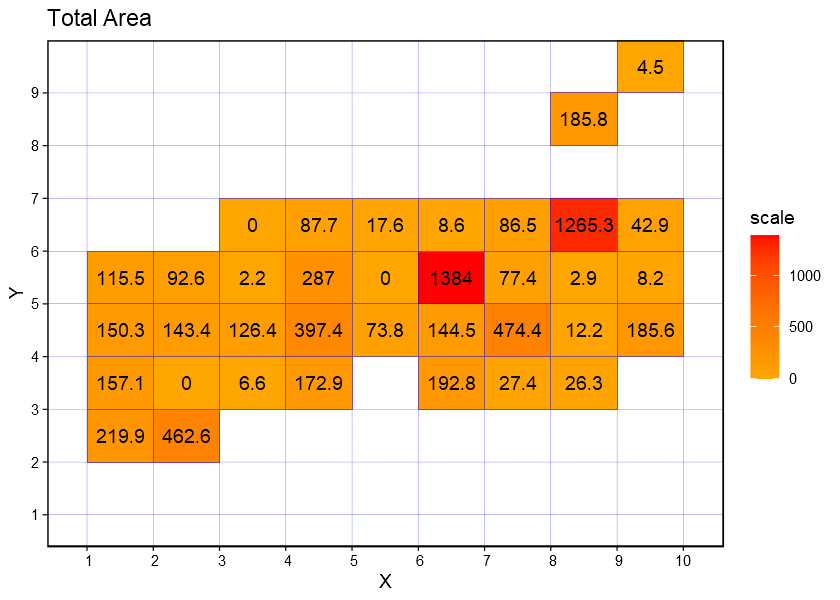

In [50]:
options(repr.plot.width=7, repr.plot.height=5) # managing the size
area_plot

With this chart we can see clearly that some areas are more relevant than others for purposes of fire prediction. We will now create a table to see explore the differences of fires among regions.   

In [51]:
df_fires$risky_region <- ifelse(df_fires$Region == 1, 1,
                                ifelse(df_fires$Region == 20, 1,
                                       ifelse(df_fires$Region == 42, 1,
                                              ifelse(df_fires$Region == 43, 1,
                                                     ifelse(df_fires$Region == 52, 1,
                                                            ifelse(df_fires$Region == 52, 59,
                                                                   0))))))
df_fires %>%
group_by(risky_region) %>%
summarize(Total_Area = sum(area, na.rm = TRUE),
          Count_Fires  = n(), 
          Mean_area = mean(area, na.rm = TRUE),
          Median_area = median(area, na.rm = TRUE),)                               


risky_region,Total_Area,Count_Fires,Mean_area,Median_area
<dbl>,<dbl>,<int>,<dbl>,<dbl>
0,5558.29,391,14.215575,0.76
1,1054.37,116,9.089397,0.00


From this table we can observe:
- That fires in Risky Areas are proportionally in much higher number. They are 6 regions out of 72 and more than 1/4 of the fires. In addition, almost 1/5 of the burned areas were in risky regions.


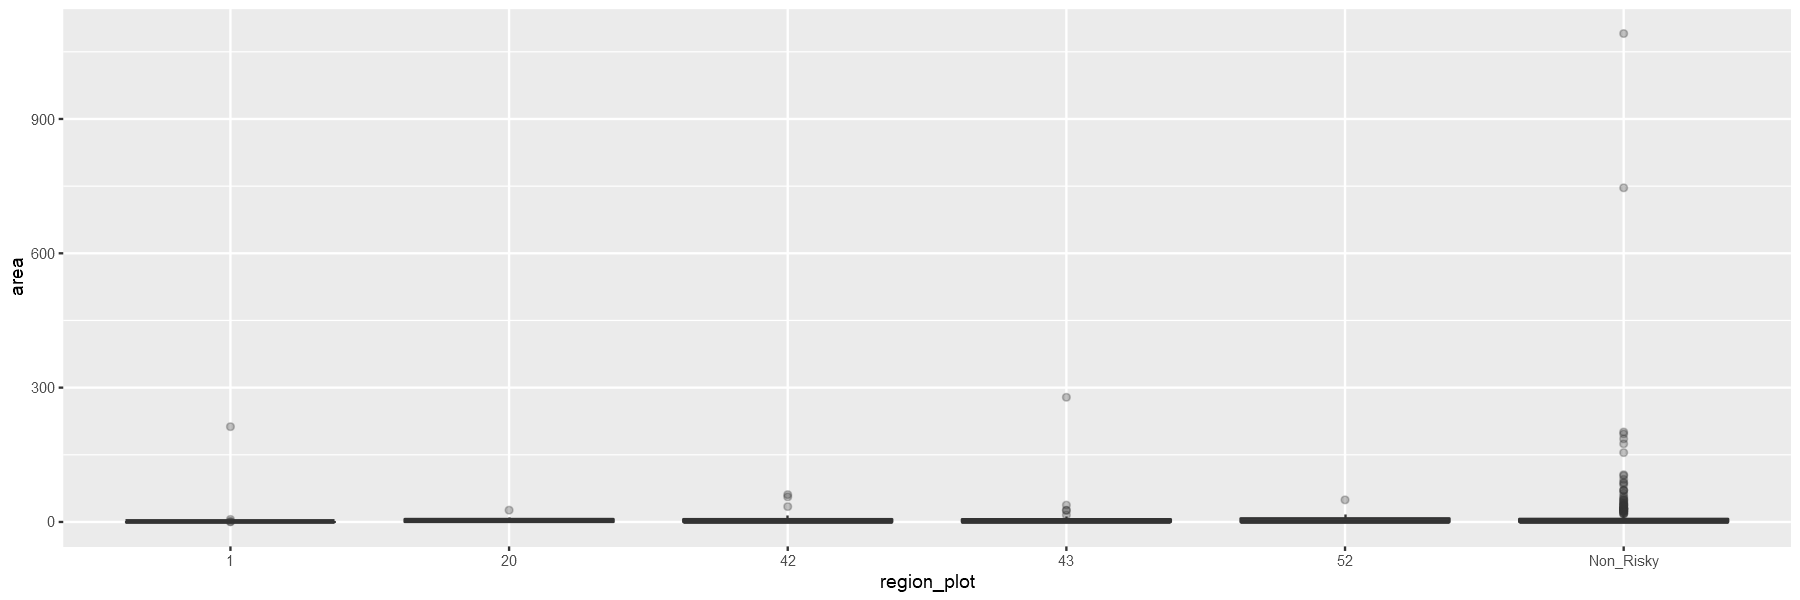

In [52]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size

df_fires$region_plot <- df_fires$region

for (i in 1:nrow(df_fires)){
    
    df_fires[i, 'region_plot'] <- ifelse(df_fires[i, 'risky_region'] == 1, df_fires[i, 'Region'], "Non_Risky")   
        
}

region59 <- df_fires[df_fires$Region == 59,]

# Top Right: Set a different color for each group
ggplot(df_fires, aes(x=region_plot, y=area, fill=region_plot)) + 
    geom_boxplot(alpha=0.3) +
    theme(legend.position="none")


#### Conclusion: 
The plot above is very conclusive, altough the oposite may be aparent. The predictors we salected from regions have:
- A small number of outliers compared to other variables.
- A big number of count of fires.
In conclusion, they are well behaved, with a stable distribution and therefore are good predictors.




#### Temporal Predictiors

We will start by ploting a chart previously developed. 

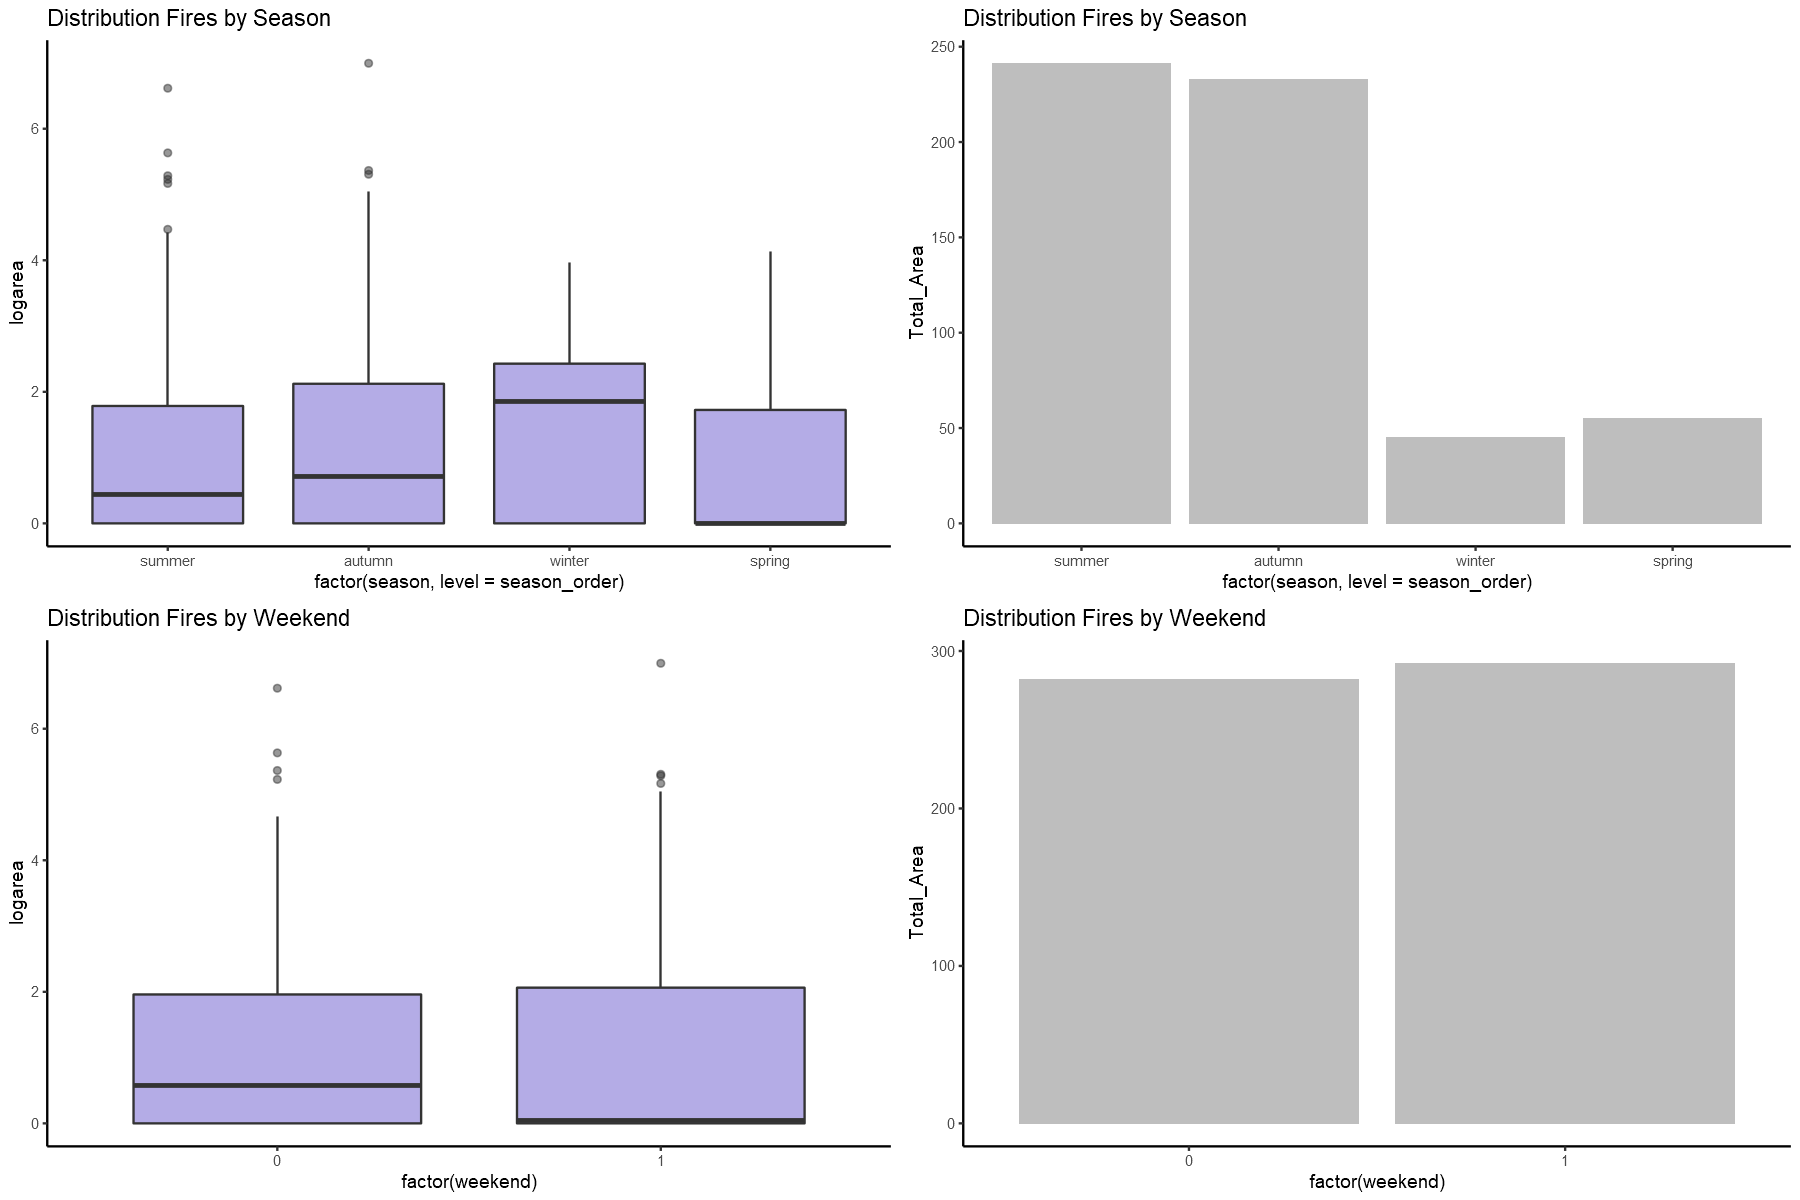

In [53]:
options(repr.plot.width=15, repr.plot.height=10) # managing the size
grid.arrange(p3, p4, p7, p8, nrow = 2, ncol = 2) # making the plot

We consider this plots sufficient to demonstrate the importance of summer and autum in predicting the fires. We have alredy made clear that all models have selected `seasonsummer` and `seasonautumn` and `weekend` as predictors with a good P-value.

#### FWI
We have demostrated the correlation between DMC:DC and used it as a predictor which made it a chosen variable. Also DMC was chosen as a relevant variable. 



#### Choosing the Best Predictor

Now, we will make a linear regression with the predictors normalized to finally compare than all in the same scale. 

In [54]:
df_fires$DMC_DC <- df_fires$DMC * df_fires$DC # missing variable

# normalize function
normalize <- function(x) {
return ((x - min(x)) / (max(x) - min(x)))
}

df_fires_normal <- df_fires 
df_fires_normal$X <- normalize(df_fires$X)
df_fires_normal$Y <- normalize(df_fires$Y)
df_fires_normal$Region1 <- normalize(df_fires$Region1)
df_fires_normal$Region20 <- normalize(df_fires$Region20)
df_fires_normal$Region42 <- normalize(df_fires$Region42)
df_fires_normal$Region43 <- normalize(df_fires$Region43)
df_fires_normal$Region52 <- normalize(df_fires$Region52)
df_fires_normal$Region59 <- normalize(df_fires$Region59)
df_fires_normal$DMC <- normalize(df_fires$DMC)
df_fires_normal$DMC_DC <- normalize(df_fires$DMC_DC)
df_fires_normal$seasonwinter <- normalize(df_fires$seasonwinter)
df_fires_normal$seasonsummer <- normalize(df_fires$seasonsummer)
df_fires_normal$weekend <- normalize(df_fires$weekend)


Final_predictors <- c('X', 'Y', 'Region1', 'Region20', 'Region42', 'Region43', 'Region52', 'Region59', 'DMC',
                      'DMC_DC', 'seasonwinter', 'seasonsummer', 'weekend', 'logarea')

summary(lm(simplify("logarea", Final_predictors), data  = df_fires_normal))


Warning message in model.matrix.default(mt, mf, contrasts):
"the response appeared on the right-hand side and was dropped"
Warning message in model.matrix.default(mt, mf, contrasts):
"problem with term 14 in model.matrix: no columns are assigned"



Call:
lm(formula = simplify("logarea", Final_predictors), data = df_fires_normal)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7669 -1.0384 -0.5150  0.8502  5.5111 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.72073    0.23018   3.131  0.00184 **
X             0.88915    0.34406   2.584  0.01004 * 
Y            -1.17358    0.55282  -2.123  0.03426 * 
Region1      -0.63040    0.36807  -1.713  0.08739 . 
Region20      0.42553    0.35053   1.214  0.22534   
Region42     -0.63138    0.34022  -1.856  0.06408 . 
Region43     -0.50556    0.26307  -1.922  0.05521 . 
Region52     -0.45570    0.45342  -1.005  0.31538   
Region59     -0.52602    0.30475  -1.726  0.08496 . 
DMC           3.62813    1.63565   2.218  0.02700 * 
DMC_DC       -2.53069    1.57345  -1.608  0.10839   
seasonwinter  0.75424    0.29133   2.589  0.00991 **
seasonsummer -0.50650    0.18525  -2.734  0.00648 **
weekend       0.03503    0.12526   0.280  0.77986   
---
Signif. c

Observations:
- X, Y, Region1, DMC, seasonsummer and seasonwinter again showed p-value under 0.05 and therefore have influence.
- DMC and DMC_DC have the highest magnitude, which in this case might mean the highest influence on the area burned. 

## 6. Conclusion <a class="anchor" id="sec_6"></a>

In this project our primary task was to model the burned areas of fires in Portugal that occured between the years of 2000 and 2003 according to 12 predictors. We have started performing an intensive exploration of the dataset in each of its dimensions. The dataset variables related time, geographic regions, metheorology and the FWI system. After performing successive tasks and reshaping the dataset with new variables different models were proposed to model the area. After arriving to a subset of 3 final models they're performance was compared according to RMSE and MAD metrics and finally the most relevant variables were identified. Some of the learning outcomes and relevat observations from the project.

- By developing heatmap plots we werre able to understand the relevance of the geographical component. Our next step was then to identify the riskiest areas and create dummy variables for each it.
- By creating new variables such as seasom and weekend, we could enhance our dataset with relevant and improved features. 
- By identifyig the strong correlation between DC and DMC we were able to use them together in a model and explore the synergy. After performing all tasks this was a selected variable. 
- Subset selection was extensevely used in our model development, which increased significantly the performance of our model with respect to ajusted R-squared and F-statistic. 
- Removing influential points was crucial to our model performance. We used Cooks distance approach.
- A honest attemp to create a model by joinning to logist and linear models. Results were not extraordinary but model building rests as an outcome. 
- Using RMSE and MAD to compare models gave a dimension of the success in the prediction task.

## 7. References <a class="anchor" id="sec_7"></a>



- Cortez, P., & Morais, A. D. J. R. (2007). A data mining approach to predict forest fires using meteorological data.
 Retrieved from http://www3.dsi.uminho.pt/pcortez/fires.pdf

- Yanghe Huo. What Influences Forest Fires Area?.
 Retrieved from http://www.columbia.edu/~yh2693/ForestFire.html

- datasharkie. (Accessed on 2020, may 09). *How to normalize data in R*. Retrieved from
https://datasharkie.com/how-to-normalize-data-in-r/

- user3459010 (2019). *Removing outliers based on cook's distance in R Language
* Retrieved from https://stats.stackexchange.com/questions/164099/removing-outliers-based-on-cooks-distance-in-r-language

- r-graph-gallery. (Accessed on 2020, may 09). *Heatmap*. Retrieved from
https://www.r-graph-gallery.com/heatmap

- zx8754 (2019). *Generate a dummy-variable*
https://stackoverflow.com/questions/11952706/generate-a-dummy-variable
